# Maud's G17

Inclination ~ 40 deg

In [1]:
from astropy import units as u
distance = 2.2*u.kpc

In [2]:
cd /orange/adamginsburg/salt/maud/

/orange/adamginsburg/salt/maud


In [3]:
ls

diskmask.reg                       G17_SPW3_2017.image.fits
endpts.reg                         G17_waterPV_withcolorcurves.pdf
G17_h30a_withNaClcontours.png      G17_waterPV_withcolorcurves.png
G17_KClPV_withcolorcurves.pdf      G17_water_withNaClcontours.pdf
G17_KClPV_withcolorcurves.png      G17_water_withNaClcontours.png
G17_KClstack.png                   indriolo/
G17_KClstack_withNaClcontours.pdf  KCl_v_le_3_stackcube.fits
G17_KClstack_withNaClcontours.png  KCl_v_le_4_stackcube.fits
G17_NaCl_mom0.png                  NaCl_stack_PV_diagram.png
G17_NaCl_mom0_ticks.png            NaCl_stack_spectrum_velocity.png
G17_NaCl_mom0_withpath.pdf         NaCl_v_le_3_stackcube.fits
G17_NaCl_mom0_withpath.png         spectra/
G17_naclPV_withcolorcurves.pdf     spectral_fits/
G17_naclPV_withcolorcurves.png     SrcI_NaCl_mom0.png
G17_naclstack_vmax.fits            SrcI_NaCl_mom0_ticks.png
G17_SPW0_2017.image.fits           SrcI.png
G17_SPW1_2017.image.fits           SrcI_withKepler.png
G17_SPW2_

In [4]:
ls indriolo/

member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor.fits


In [5]:
ls spectra

figures/
G17_SPW0_2017.image_meanspec.fits
G17_SPW0_2017.image_moment_stack.fits
G17_SPW0_2017.image_stack.fits
G17_SPW1_2017.image_meanspec.fits
G17_SPW1_2017.image_moment_stack.fits
G17_SPW1_2017.image_stack.fits
G17_SPW2_2017.image_meanspec.fits
G17_SPW2_2017.image_moment_stack.fits
G17_SPW2_2017.image_stack.fits
G17_SPW3_2017.image_meanspec.fits
G17_SPW3_2017.image_moment_stack.fits
G17_SPW3_2017.image_stack.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor_meanspec.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor_stack.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor_meanspec.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor_stack.fits
NaCl_v_le_3_stackcube_meanspec.fits


In [6]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b66c13be7c0>

In [7]:
from astropy.table import Table
from astropy import table

In [8]:
import pprint

In [9]:
import scipy, scipy.ndimage

In [10]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
import salt_tables
import imp
imp.reload(salt_tables)
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [11]:
import regions
from astropy import units as u, coordinates
reg = regions.CircleSkyRegion(coordinates.SkyCoord('18h22m26.385s −13:30:11.9700', frame='icrs', unit=(u.h, u.deg)), radius=0.4*u.arcsec)
regsm = regions.CircleSkyRegion(coordinates.SkyCoord('18h22m26.385s −13:30:11.9700', frame='icrs', unit=(u.h, u.deg)), radius=0.3*u.arcsec)
regvsm = regions.CircleSkyRegion(coordinates.SkyCoord('18h22m26.385s −13:30:11.9700', frame='icrs', unit=(u.h, u.deg)), radius=0.15*u.arcsec)

# NaCl Stackl

In [12]:
from spectral_cube.analysis_utilities import stack_cube

In [13]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [14]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [15]:
cubes = [SpectralCube.read(fn) for fn in (glob.glob('G17_SPW[0-3]_2017.image.fits'))]

linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [16]:
cubes = [cc.subcube_from_regions([reg]).to(u.K) for cc in cubes]
# use this snippet if we want only the cubes that contain NaCl low-J lines - we may want more thna just that for use below though
# if np.any([((frq > cc.spectral_extrema[0]) & (frq < cc.spectral_extrema[1])) for frq in linelist])]
cubes

[VaryingResolutionSpectralCube with shape=(1920, 159, 160) and unit=K:
  n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 230937801859.600 Hz:232811916796.997 Hz,
 VaryingResolutionSpectralCube with shape=(3840, 159, 160) and unit=K:
  n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 216746373866.513 Hz:218620977109.000 Hz,
 VaryingResolutionSpectralCube with shape=(1920, 159, 160) and unit=K:
  n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233045

In [17]:
beams = radio_beam.Beams(beams=[
    (cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
     if hasattr(cube, 'beams')
     else cube.beam) for cube in cubes])
cb = beams.common_beam()
print(beams)
print(f"Common beam: {cb}")
cb

[2.15772965e-14 2.21003232e-14 2.04809940e-14 2.15444432e-14] sr
Common beam: 2.2503384343455102e-14 sr


Beam: BMAJ=0.0381048412380685 arcsec BMIN=0.02217448423776735 arcsec BPA=45.03730920960483 deg

In [18]:
(cb.major * distance).to(u.au, u.dimensionless_angles())

<Quantity 83.83065072 AU>

In [19]:
(cb.minor * distance).to(u.au, u.dimensionless_angles())

<Quantity 48.78386532 AU>

In [20]:
vcen = 30*u.km/u.s
water_cube = (SpectralCube.read('G17_SPW2_2017.image.fits')
              .with_spectral_unit(u.km/u.s, rest_value=232.68670*u.GHz, velocity_convention='radio')
              .subcube_from_regions([reg])
              .spectral_slab(vcen-50*u.km/u.s, vcen+50*u.km/u.s)
              .to(u.K))
water_cube

VaryingResolutionSpectralCube with shape=(81, 159, 160) and unit=K:
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:     81  type_s: VRAD      unit_s: km / s  range:      -20.404 km / s:      80.257 km / s

In [21]:
h30a_cube = (SpectralCube.read('G17_SPW2_2017.image.fits')
              .with_spectral_unit(u.km/u.s, rest_value=231.900928*u.GHz, velocity_convention='radio')
              .subcube_from_regions([reg])
              .spectral_slab(vcen-80*u.km/u.s, vcen+80*u.km/u.s)
              .to(u.K))
h30a_cube

VaryingResolutionSpectralCube with shape=(128, 159, 160) and unit=K:
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:    128  type_s: VRAD      unit_s: km / s  range:      -50.257 km / s:     110.083 km / s

In [22]:
indriolocubes = [SpectralCube.read(fn).subcube_from_regions([reg]).to(u.K) for fn in glob.glob('indriolo/*.cube.I.pbcor.fits')]

In [23]:
[data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables]

[<Column name='Species' dtype='str24' length=4>
 23Na-35Clv=2-2 J=17-16
 23Na-35Clv=1-1 J=17-16
 23Na-35Clv=1-1 J=18-17
 23Na-35Clv=0-0 J=18-17,
 <Column name='Species' dtype='str24' length=0>]

In [24]:
from astropy import log
log.setLevel('INFO')

In [25]:
#log.setLevel('DEBUG')
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=-10*u.km/u.s,
                   vmax=50*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

Mean of empty slice


In [26]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits', use_dask=True)
stackc

DaskSpectralCube with shape=(91, 159, 160) and unit=K and chunk size (91, 159, 160):
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:      -10.197 km / s:      50.245 km / s

In [27]:
from astropy.visualization import simple_norm

In [28]:
m0 = stackc[:,18:-20,18:-20].moment0()

In [29]:
pixscale = (m0.wcs.proj_plane_pixel_scales())[0]
pixscale_au = (pixscale * 2.4*u.kpc).to(u.au, u.dimensionless_angles())
pixscale_au

<Quantity 12. AU>

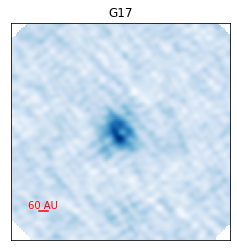

In [30]:
pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
pl.title("G17")
pl.plot([15,20], [16,16], color='r')
pl.text(17.5, 17, '60 AU', horizontalalignment='center', color='r')
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([])
pl.gca().set_xticks([])
pl.gca().set_yticks([])
pl.savefig("G17_NaCl_mom0.png", bbox_inches='tight')

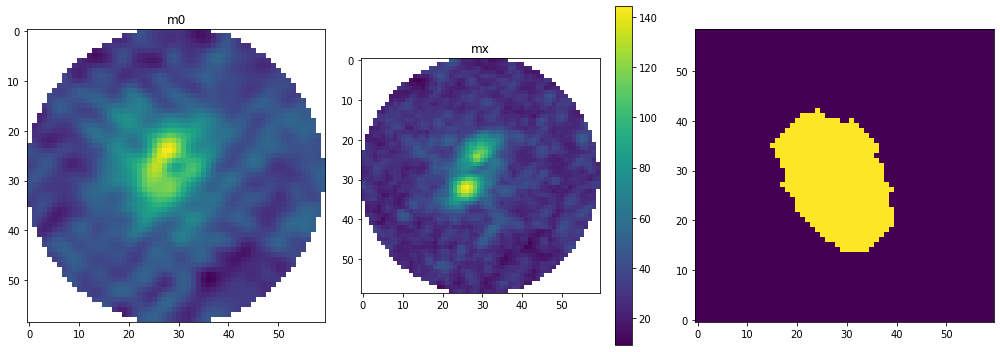

<Figure size 432x288 with 0 Axes>

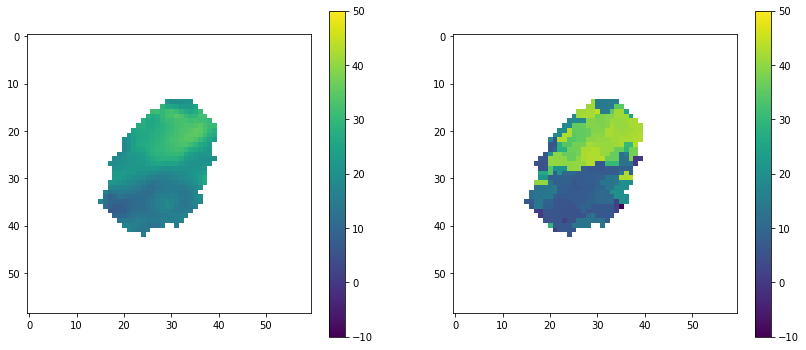

In [31]:
stackc = stackc.subcube_from_regions([regvsm])

jtok = stackc.beam.jtok(217*u.GHz)


pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.0016*jtok
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
msk3d = (stackc > 0.0003*jtok).include()
msk3d = binary_erosion(msk3d, iterations=1)
msk3d = binary_dilation(msk3d, iterations=2)
msk3d = msk3d.compute()

m1 = stackc.with_mask(msk).with_mask(msk3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=50)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=50)
pl.colorbar()

vmap_mom = m1.hdu
vmap = mxv.hdu
mxv.write("G17_naclstack_vmax.fits", overwrite=True)

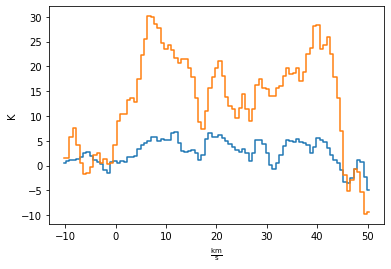

In [32]:
stackc.mean(axis=(1,2)).quicklook()
stackc.with_mask(msk).mean(axis=(1,2)).quicklook()
pl.savefig("NaCl_stack_spectrum_velocity.png")

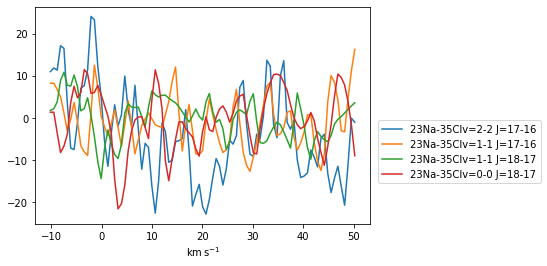

In [33]:
for cutout, linef in zip(cutouts, linenames):
    cutout = SpectralCube(data=cutout, header=stackc.header, wcs=wcs.WCS(stackc.header)).subcube_from_regions([regvsm])
    sp = cutout.with_mask(msk).mean(axis=(1,2))
    pl.plot(sp.spectral_axis, sp.value, label=str(linef))
    pl.legend(loc='upper left', bbox_to_anchor=(1.01,0.5,0,0))

# Past exploration of vmap

In [34]:
cubespw2 = SpectralCube.read('G17_SPW2_2017.image.fits', use_dask=True).subcube_from_regions([reg])
cubespw2

DaskVaryingResolutionSpectralCube with shape=(1920, 159, 160) and unit=Jy / beam and chunk size (320, 86, 123):
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 230937801859.600 Hz:232811916796.997 Hz

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


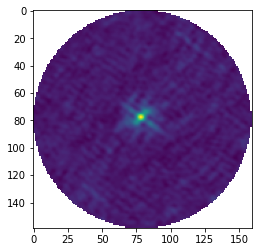

In [35]:
m0 = cubespw2.spectral_slab(231.8187*u.GHz, 231.9154*u.GHz).moment0()
m0.quicklook()

naclv1 = cubespw2.subcube_from_regions([regvsm]).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=232509.97700*u.MHz).spectral_slab(0*u.km/u.s, 40*u.km/u.s)
m0 = naclv1.moment0()
m0.quicklook()

mx = naclv1.max(axis=0)
mx.quicklook()
pl.colorbar()
msk = mx > 0.00245*mx.unit
msk = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(msk, iterations=1), iterations=7)
pl.imshow(msk)
pl.figure()


m1 = naclv1.with_mask(msk).with_mask(naclv1 > 0.0005*naclv1.unit).moment1()
pl.imshow(m1.value, vmin=0, vmax=40)
pl.colorbar()
vmap = m1.hdu

cubespw3 = SpectralCube.read('G17_SPW3_2017.image.fits', use_dask=True).subcube_from_regions([reg])

naclv0 = cubespw3.subcube_from_regions([regvsm]).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=234251.91200*u.MHz).spectral_slab(0*u.km/u.s, 40*u.km/u.s)
m0 = naclv0.moment0()
m0.quicklook()

mx = naclv0.max(axis=0)
mx.quicklook()
pl.colorbar()
msk = mx > 0.004*mx.unit
msk = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(msk, iterations=1), iterations=7)
pl.imshow(msk)
pl.figure()


m1 = naclv0.with_mask(msk).with_mask(naclv0 > 0.0005*naclv1.unit).moment1()
pl.imshow(m1.value, vmin=0, vmax=40)
pl.colorbar()
vmap = m1.hdu



In [36]:
cubespw1 = SpectralCube.read('G17_SPW1_2017.image.fits', use_dask=True).subcube_from_regions([reg])
cubespw1

DaskVaryingResolutionSpectralCube with shape=(1920, 159, 160) and unit=Jy / beam and chunk size (320, 86, 123):
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 218854211902.303 Hz:220728326839.700 Hz

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


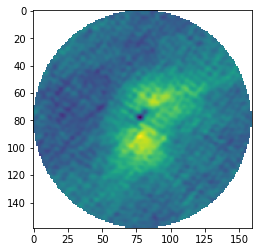

In [37]:
m0 = cubespw1.spectral_slab(219.9246*u.GHz, 219.9422*u.GHz).moment0()
m0.quicklook()

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


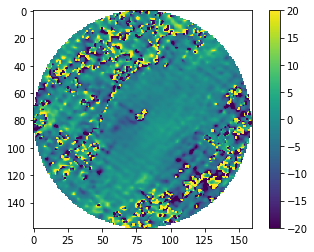

In [38]:
m1 = cubespw1.spectral_slab(219.9246*u.GHz, 219.9422*u.GHz).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=219.9320*u.GHz).moment1()
m1.quicklook()
pl.imshow(m1.value, vmin=-20, vmax=20)
pl.colorbar()

In [39]:
import glob
import pyspeckit

In [40]:
ls *fits

G17_naclstack_vmax.fits   G17_SPW2_2017.image.fits   KCl_v_le_4_stackcube.fits
G17_SPW0_2017.image.fits  G17_SPW3_2017.image.fits   NaCl_v_le_3_stackcube.fits
G17_SPW1_2017.image.fits  KCl_v_le_3_stackcube.fits

spectral_fits:


<Figure size 432x288 with 0 Axes>

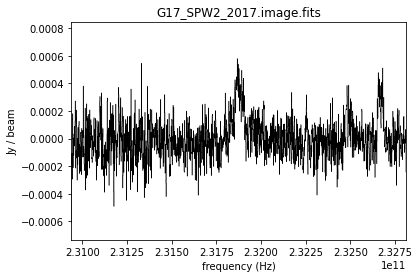

<Figure size 432x288 with 0 Axes>

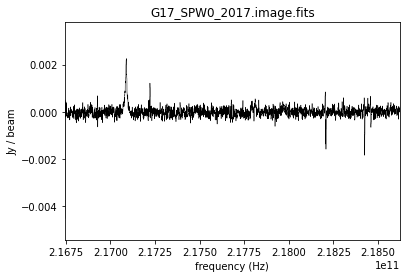

<Figure size 432x288 with 0 Axes>

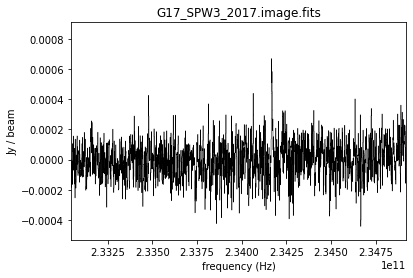

<Figure size 432x288 with 0 Axes>

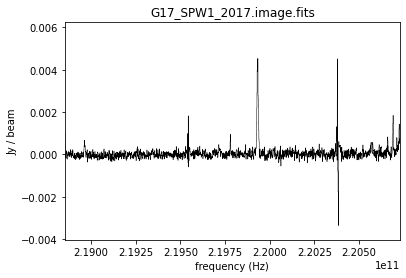

In [41]:
avspectra = []
for fn in glob.glob("*image.fits"):
    cube = SpectralCube.read(fn).subcube_from_regions([regvsm])
    sp = pyspeckit.Spectrum(xarr=cube.spectral_axis, data=cube.mean(axis=(1,2)))
    pl.figure()
    sp.plotter()
    pl.title(fn)
    
    sp.specname = fn
    
    avspectra.append(sp)

sp.plotter(xmin=219.8e9, xmax=220.0e9)
sp.specfit(gueses=[0.002, 219.98e9, 0.01e9])

In [42]:
from astroquery.splatalogue import Splatalogue
from astropy import constants

frq = sp.specfit.parinfo[1].value*u.Hz
vel = 0*u.km/u.s # 22*u.km/u.s
width = 5*u.km/u.s
fmin = frq * (1-(vel+width)/constants.c)
fmax = frq * (1-(vel-width)/constants.c)
Splatalogue.query_lines(fmin, fmax, line_lists=['JPL']).pprint(max_lines=1000, max_width=250)

# Spectral stacking

DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 230937801859.600 Hz:232811916796.997 Hz


DaskVaryingResolutionSpectralCube with shape=(3840, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 216746373866.513 Hz:218620977109.000 Hz


DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233045395742.900 Hz:234919510680.414 Hz


DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 218854211902.303 Hz:220728326839.700 Hz


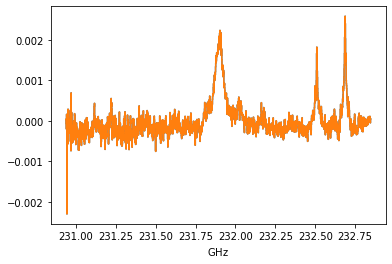

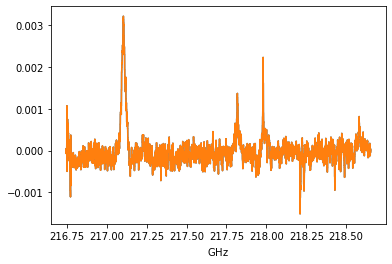

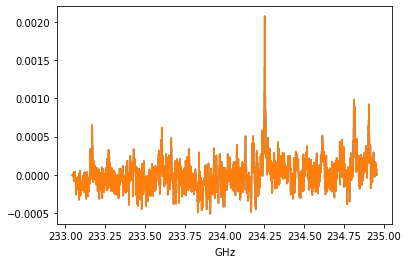

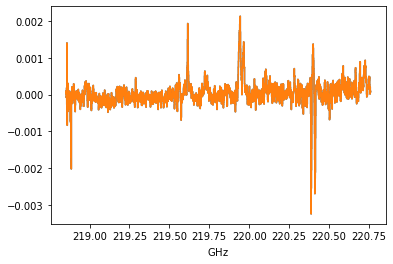

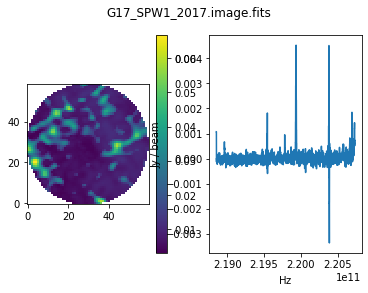

In [43]:
import glob
import spectral_cube.analysis_utilities
import reproject

flist = [x for x in glob.glob('*.fits') if 'spectra' not in x]
flist = glob.glob('G17_SPW[0-3]_2017.image.fits')
for fn in flist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions([regvsm])
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)

    # convert the cube to velocity units with an arbitrary reference point
    # (this step assumes the cube is in frequency or wavelength; if the
    # cube is not, it should be skipped)
    if not cube.spectral_axis.unit.is_equivalent(u.km/u.s):
        fullcube = cube.with_spectral_unit(u.km/u.s,
                                           velocity_convention='radio',
                                           rest_value=cube.spectral_axis.mean())
    else:
        fullcube = cube

    # force the fullcube to be a regular cube, not varying res
    # (resolution variation is negligible and I don't want to spend time smoothing)
    commonbeam = fullcube.beams.common_beam()
    fullcube = SpectralCube(data=fullcube._data, wcs=fullcube.wcs, beam=commonbeam, mask=fullcube.mask,)

    scube = fullcube.subcube_from_regions([regvsm])#.convolve_to(fullcube.beams.common_beam())

    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)


    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s)
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 230937801859.600 Hz:232811916796.997 Hz


DaskVaryingResolutionSpectralCube with shape=(3840, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 216746373866.513 Hz:218620977109.000 Hz


DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 233045395742.900 Hz:234919510680.414 Hz


DaskVaryingResolutionSpectralCube with shape=(1920, 512, 512) and unit=Jy / beam and chunk size (320, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   275.609511 deg:  275.610241 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -13.503689 deg:  -13.502979 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 218854211902.303 Hz:220728326839.700 Hz


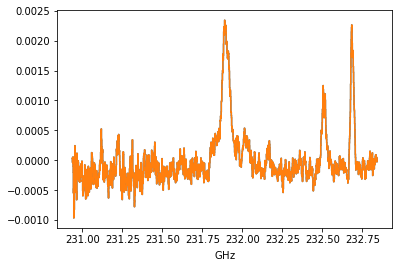

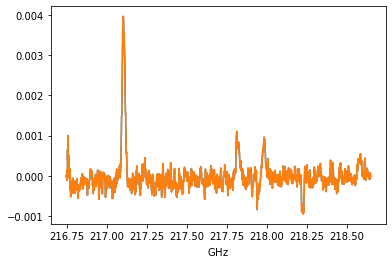

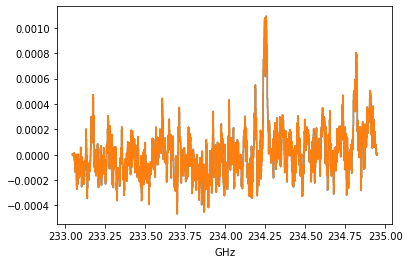

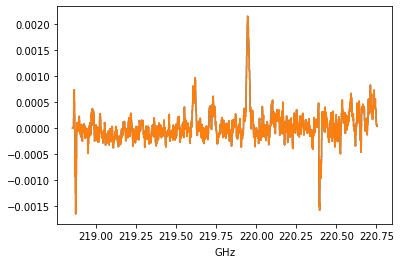

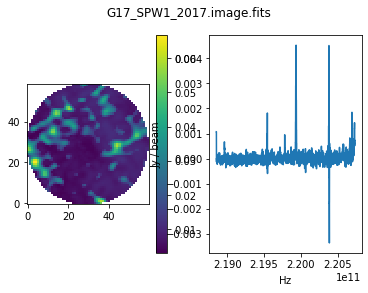

In [44]:
import glob
import spectral_cube.analysis_utilities
import reproject

flist = [x for x in glob.glob('*.fits') if 'spectra' not in x]
flist = glob.glob('G17_SPW[0-3]_2017.image.fits')
for fn in flist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    scube = cube.subcube_from_regions([regvsm])
    print(scube)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)

    # convert the cube to velocity units with an arbitrary reference point
    # (this step assumes the cube is in frequency or wavelength; if the
    # cube is not, it should be skipped)
    if not cube.spectral_axis.unit.is_equivalent(u.km/u.s):
        fullcube = cube.with_spectral_unit(u.km/u.s,
                                           velocity_convention='radio',
                                           rest_value=cube.spectral_axis.mean())
    else:
        fullcube = cube

    # force the fullcube to be a regular cube, not varying res
    # (resolution variation is negligible and I don't want to spend time smoothing)
    commonbeam = fullcube.beams.common_beam()
    fullcube = SpectralCube(data=fullcube._data, wcs=fullcube.wcs, beam=commonbeam, mask=fullcube.mask,)

    scube = fullcube.subcube_from_regions([regvsm])#.convolve_to(fullcube.beams.common_beam())

    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap_mom,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)


    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s)
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_moment_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_moment_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_moment_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [45]:
ls spectra

figures/
G17_SPW0_2017.image_meanspec.fits
G17_SPW0_2017.image_moment_stack.fits
G17_SPW0_2017.image_stack.fits
G17_SPW1_2017.image_meanspec.fits
G17_SPW1_2017.image_moment_stack.fits
G17_SPW1_2017.image_stack.fits
G17_SPW2_2017.image_meanspec.fits
G17_SPW2_2017.image_moment_stack.fits
G17_SPW2_2017.image_stack.fits
G17_SPW3_2017.image_meanspec.fits
G17_SPW3_2017.image_moment_stack.fits
G17_SPW3_2017.image_stack.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor_meanspec.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor_stack.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor_meanspec.fits
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor_stack.fits
NaCl_v_le_3_stackcube_meanspec.fits


<Figure size 432x288 with 0 Axes>

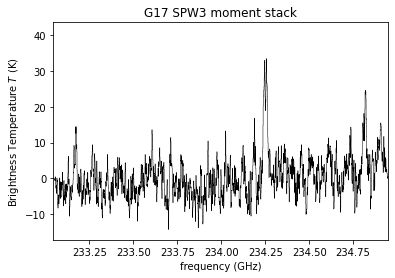

<Figure size 432x288 with 0 Axes>

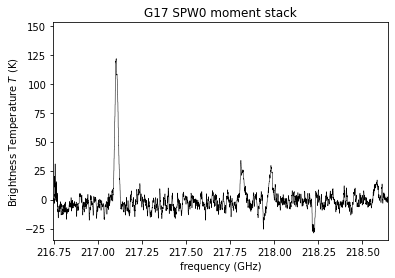

<Figure size 432x288 with 0 Axes>

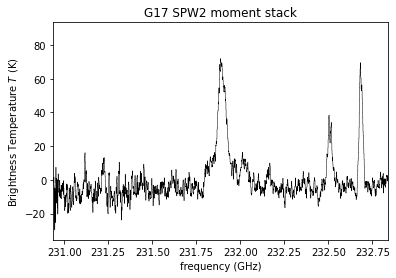

<Figure size 432x288 with 0 Axes>

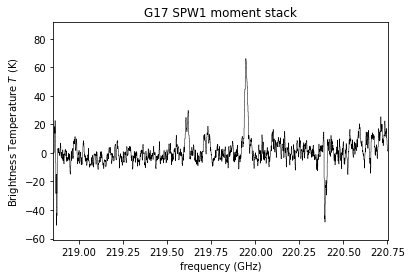

In [46]:
momstackspectra = []

jtok = stackc.beam.jtok(217*u.GHz)

for fn in glob.glob("spectra/*moment_stack.fits"):

    sp = pyspeckit.Spectrum(fn)

    sp.data *= jtok.value
    sp.unit = u.K
    
    pl.figure()
    sp.plotter()
    
    sp.specname = 'G17 ' + fn.split("_")[1]+ " moment stack"
    pl.title(sp.specname)

    
    momstackspectra.append(sp)

<Figure size 432x288 with 0 Axes>

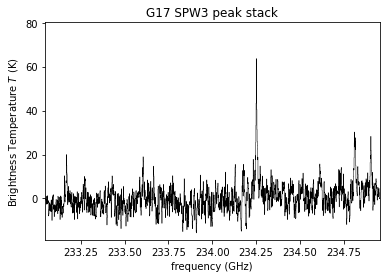

<Figure size 432x288 with 0 Axes>

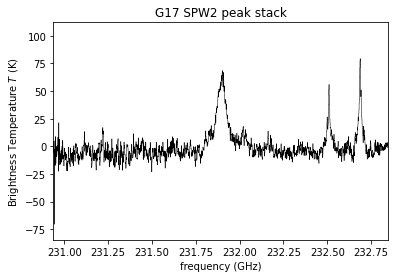

<Figure size 432x288 with 0 Axes>

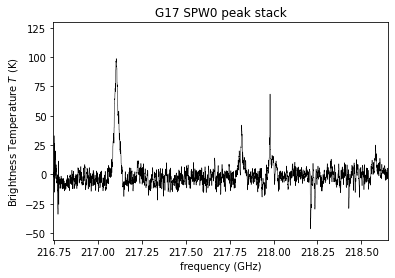

<Figure size 432x288 with 0 Axes>

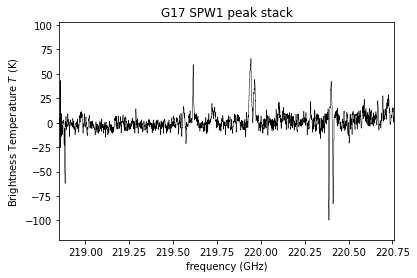

In [47]:
# max stack
spectra = []

jtok = stackc.beam.jtok(217*u.GHz)

for fn in glob.glob("spectra/*image_stack.fits"):

    sp = pyspeckit.Spectrum(fn)
    sp.specname = 'G17 ' + fn.split("_")[1]+ " peak stack"

    
    sp.data *= jtok.value
    sp.unit = u.K
    
    pl.figure()
    sp.plotter()
    pl.title(sp.specname)
    
    spectra.append(sp)

In [48]:
if not os.path.exists('spectra'):
    os.mkdir('spectra')
if not os.path.exists('spectra/figures'):
    os.mkdir('spectra/figures')   

In [49]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines, all_lines
'SO65-54' in all_lines

True

In [50]:
import imp
import overplot_saltlines
imp.reload(overplot_saltlines)
import lines
imp.reload(lines)
from overplot_saltlines import overplot_saltlines, all_lines, linetexnames


G17_SPW3_peak_stack
G17_SPW2_peak_stack
G17_SPW0_peak_stack
G17_SPW1_peak_stack


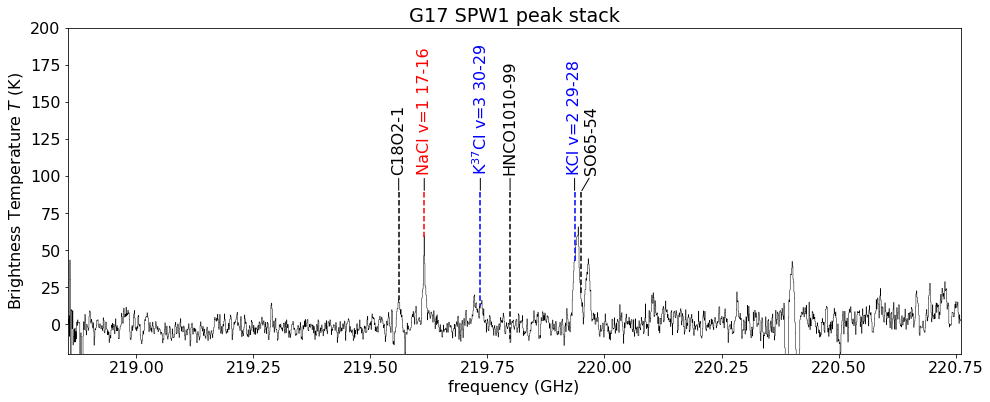

In [51]:
# these are stacked spectra
overplot_saltlines(spectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymin=-20, ymax=200, yfrac=0.55)

G17_SPW3_moment_stack
G17_SPW0_moment_stack
G17_SPW2_moment_stack
G17_SPW1_moment_stack


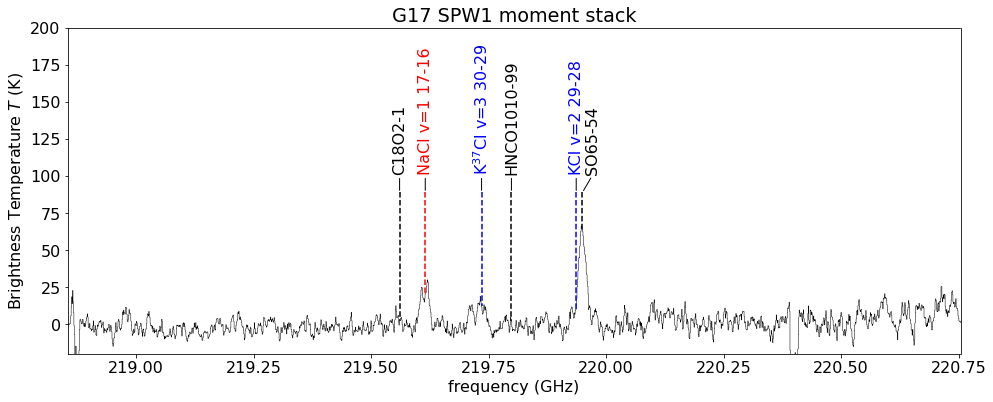

In [52]:
# these are stacked spectra
overplot_saltlines(momstackspectra, vcen=0*u.km/u.s, savepath='spectra/figures', ymin=-20, ymax=200, yfrac=0.55)

In [53]:
from IPython.display import Image

In [54]:
pwd

'/orange/adamginsburg/salt/maud'

In [55]:
ls -lhrt spectra/figures/color_labels*

-rw-r--r-- 1 adamginsburg adamginsburg 118K Sep 17  2021 spectra/figures/color_labels_G17_SPW2_2017.image.png
-rw-r--r-- 1 adamginsburg adamginsburg 124K Sep 17  2021 spectra/figures/color_labels_G17_SPW0_2017.image.png
-rw-r--r-- 1 adamginsburg adamginsburg 108K Sep 17  2021 spectra/figures/color_labels_G17_SPW3_2017.image.png
-rw-r--r-- 1 adamginsburg adamginsburg  77K Sep 17  2021 spectra/figures/color_labels_G17_SPW1_2017.image.png
-rw-r--r-- 1 adamginsburg adamginsburg  56K May 31 11:12 spectra/figures/color_labels_G17_SPW3_2017.image_moment_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  63K May 31 11:12 spectra/figures/color_labels_G17_SPW2_2017.image_moment_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  79K May 31 11:12 spectra/figures/color_labels_G17_SPW0_2017.image_moment_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  59K May 31 11:12 spectra/figures/color_labels_G17_SPW1_2017.image_moment_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  57K May 31 11:21 spectra/fig

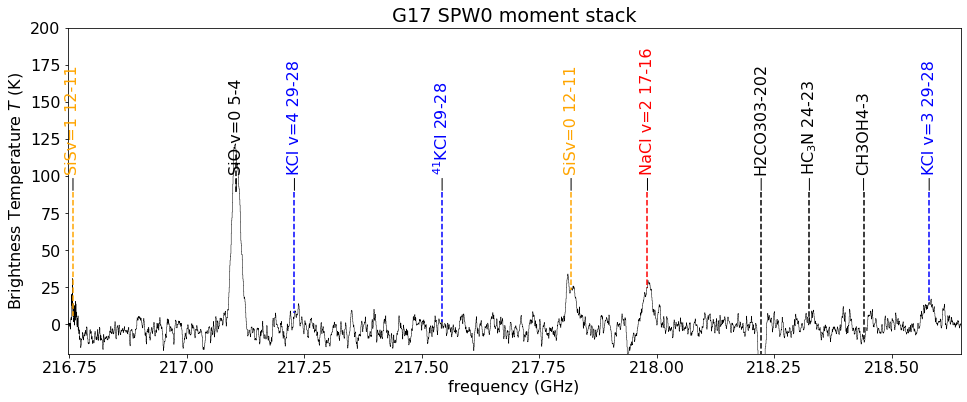

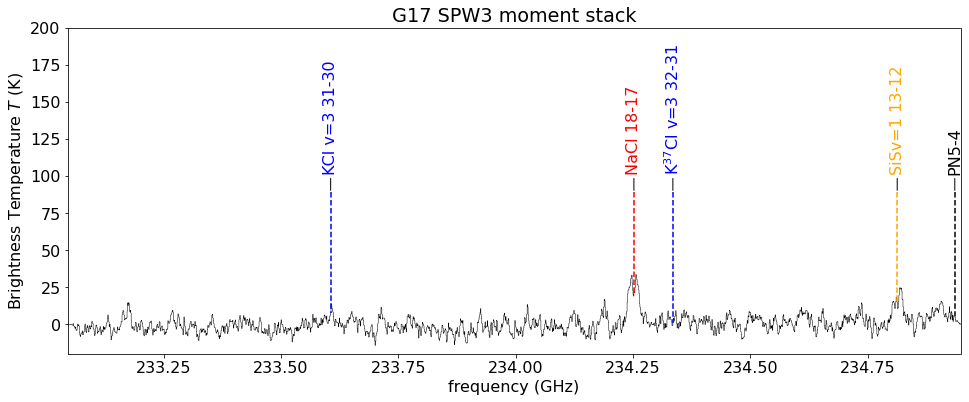

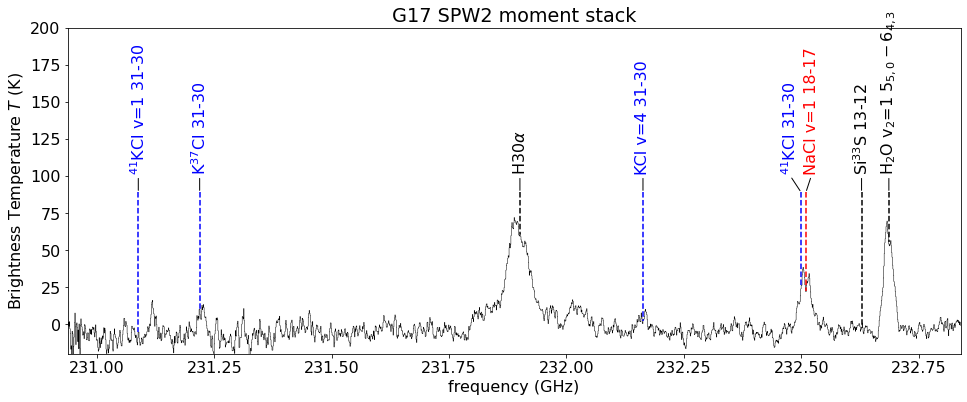

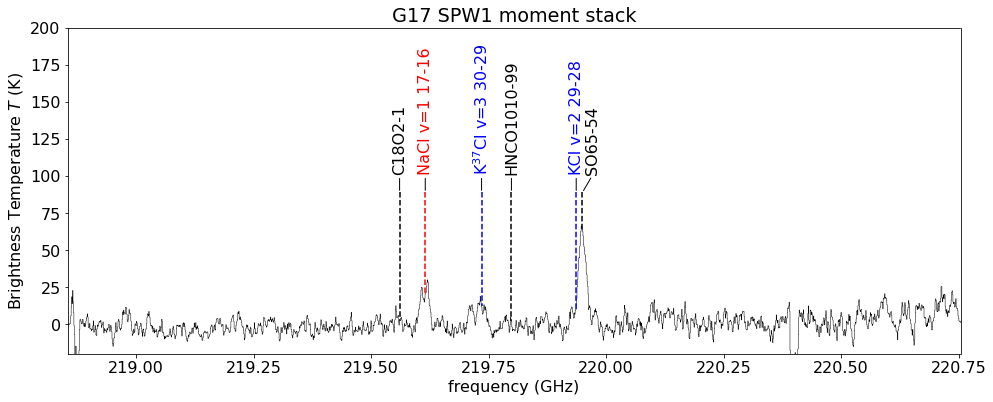

In [56]:
for fn in glob.glob('spectra/figures/color_labels_G17_SPW[0-4]_moment_stack.png'):
    display(Image(fn))

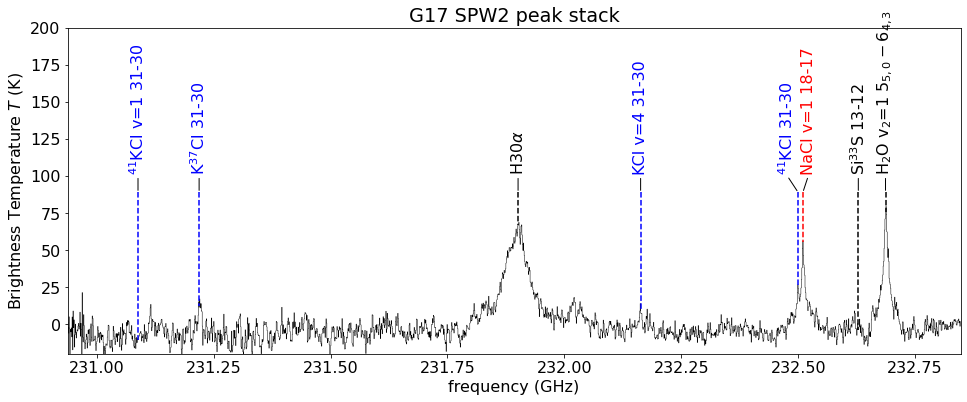

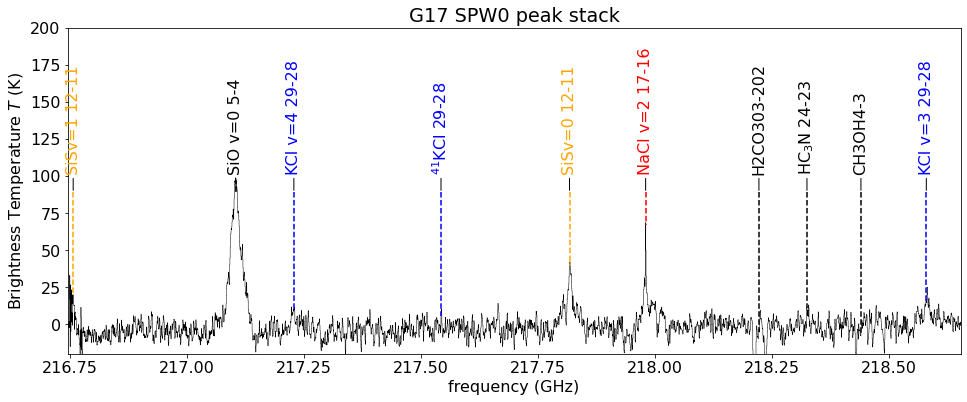

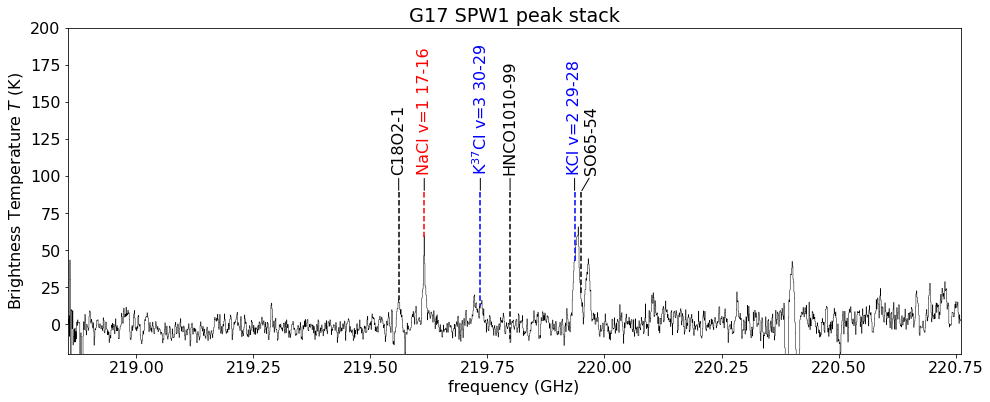

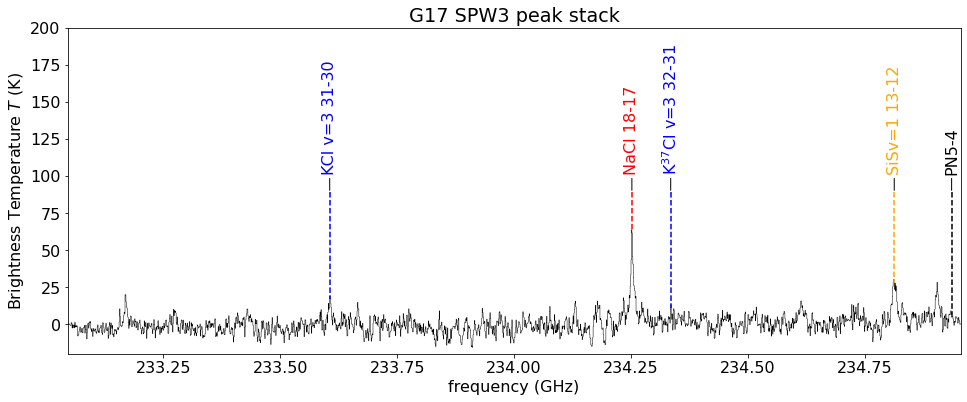

In [57]:
for fn in glob.glob('spectra/figures/color_labels_G17_SPW[0-4]_peak_stack.png'):
    display(Image(fn))

# Stack the KCl cubes to see if we come up with anything 

# KCl Stackl

In [58]:
# table 5 is double-rare, not detected
kcltables = salt_tables[:3]#  + salt_tables[5:]

In [59]:
# cubes are already loaded
# cubes = [SpectralCube.read(fn).subcube_from_regions([reg]) for fn in (glob.glob('G17_SPW[0-3]_2017.image.fits'))]
# beams = radio_beam.Beams(beams=[cube.beams.common_beam() for cube in cubes])
# cb=beams.common_beam()
linelistK = np.concatenate([data['Freq'][(data['vu'] <= 4) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in kcltables])
linenamesK = np.concatenate( [data['Species'][(data['vu'] <= 4) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in kcltables] )
(linelistK, linenamesK)

(<Quantity [217.22891176, 218.5797076 , 219.93611261, 232.16184646,
            233.60569798, 218.39656825, 219.73475809, 231.21883931,
            234.33493148, 217.54316883, 219.59177028, 231.08814962,
            232.49980161, 234.18192351] GHz>,
 array(['39K-35Clv=4-4 J=29-28', '39K-35Clv=3-3 J=29-28',
        '39K-35Clv=2-2 J=29-28', '39K-35Clv=4-4 J=31-30',
        '39K-35Clv=3-3 J=31-30', '39K-37Clv=4-4 J=30-29',
        '39K-37Clv=3-3 J=30-29', '39K-37Clv=0-0 J=31-30',
        '39K-37Clv=3-3 J=32-31', '41K-35Clv=0-0 J=29-28',
        '41K-35Clv=4-4 J=30-29', '41K-35Clv=1-1 J=31-30',
        '41K-35Clv=0-0 J=31-30', '41K-35Clv=4-4 J=32-31'], dtype='<U25'))

In [60]:
rows = [data[(data['vu'] <= 4) &
             np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                      (data['Freq'].quantity < cube.spectral_extrema[1]))
                     for cube in cubes],
                    axis=0)]
        for data in kcltables]
KCl_inband = table.vstack(rows)
KCl_inband

upper_state,lower_state,Aij,Frequency_cm,Freq,E_U,E_L,QNs,vu,vl,Ju,Jl,gu,gl,Species
,,1 / s,1 / cm,GHz,K,K,,,,,,,,
int64,int64,float64,float64,float64,float64,float64,str17,int64,int64,int64,int64,int64,int64,str25
2037,2036,0.0065775,7.245516,217.22891175712175,1733.213093745079,1722.7884094074825,v=4-4 J=29-28,4,4,29,28,944,912,39K-35Clv=4-4 J=29-28
1535,1534,0.0066243,7.290563,218.57970759934983,1345.0583565643997,1334.5688596233451,v=3-3 J=29-28,3,3,29,28,944,912,39K-35Clv=3-3 J=29-28
1033,1032,0.0066713,7.335813,219.93611261476423,953.5558794307203,943.0012778144056,v=2-2 J=29-28,2,2,29,28,944,912,39K-35Clv=2-2 J=29-28
2039,2038,0.0080403,7.743592,232.16184645668199,1755.1374506752938,1743.9961458684122,v=4-4 J=31-30,4,4,31,30,1008,976,39K-35Clv=4-4 J=31-30
1537,1536,0.0080975,7.791745,233.60569798423805,1367.1190419652214,1355.9084557124208,v=3-3 J=31-30,3,3,31,30,1008,976,39K-35Clv=3-3 J=31-30
2038,2037,0.0066834,7.284444,218.3965682524781,1717.1701061368606,1706.689413074434,v=4-4 J=30-29,4,4,30,29,976,944,39K-37Clv=4-4 J=30-29
1536,1535,0.0067303,7.32908,219.7347580948684,1334.4294262712083,1323.8845119428167,v=3-3 J=30-29,3,3,30,29,976,944,39K-37Clv=3-3 J=30-29
32,31,0.0075851,7.712206,231.21883930648752,177.67434349526533,166.57819615441105,v=0-0 J=31-30,0,0,31,30,1008,976,39K-37Clv=0-0 J=31-30


In [61]:
# exclude lines with contaminants
# 41KCl v=4 J=30-20 is the worst, apparently, b/c of NaCl v=1 17-16
# 41KCl v=0 J=31-30 is on top of NaCl v=1 18-17
# KCl v=2 29-28 is double-peaked; not clear what's up there
# 41KCl v=0 J=29-28 just looks like a nondetection?
# 39K-37Cl v=4 J=30-29 nondetection
# 39K-37Cl v=3 J=32-31 nondetection
# 41K-35Cl v=1 J=31-30 nondetection
exclude = ('41K-35Clv=0-0 J=31-30',
           '41K-35Clv=4-4 J=30-29',
           '39K-35Clv=2-2 J=29-28',
           '41K-35Clv=0-0 J=29-28',
           '39K-37Clv=4-4 J=30-29',
           '39K-37Clv=3-3 J=32-31',
           '41K-35Clv=1-1 J=31-30',           
          )
incl = np.all([linenamesK != ex for ex in exclude], axis=0)
linelistK = linelistK[incl]
linenamesK = linenamesK[incl]
linelistK, linenamesK
pprint.pprint(dict(zip(linelistK, linenamesK)))

{<Quantity 217.22891176 GHz>: '39K-35Clv=4-4 J=29-28',
 <Quantity 218.5797076 GHz>: '39K-35Clv=3-3 J=29-28',
 <Quantity 219.73475809 GHz>: '39K-37Clv=3-3 J=30-29',
 <Quantity 231.21883931 GHz>: '39K-37Clv=0-0 J=31-30',
 <Quantity 232.16184646 GHz>: '39K-35Clv=4-4 J=31-30',
 <Quantity 233.60569798 GHz>: '39K-35Clv=3-3 J=31-30',
 <Quantity 234.18192351 GHz>: '41K-35Clv=4-4 J=32-31'}


In [62]:
stackK, cutoutsK = stack_cube(cubes,
                   linelist=linelistK,
                   vmin=-10*u.km/u.s,
                   vmax=50*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
stackK.to(u.K).write('KCl_v_le_4_stackcube.fits', overwrite=True)

Mean of empty slice


In [63]:
stackKc = SpectralCube.read('KCl_v_le_4_stackcube.fits')
stackKc

SpectralCube with shape=(90, 159, 160) and unit=K:
 n_x:    160  type_x: RA---SIN  unit_x: deg    range:   275.609824 deg:  275.610051 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -13.503435 deg:  -13.503215 deg
 n_s:     90  type_s: VRAD      unit_s: km / s  range:       -9.981 km / s:      49.996 km / s

In [64]:
regdisk = regions.Regions.read('diskmask.reg')

All-NaN slice encountered
invalid value encountered in true_divide


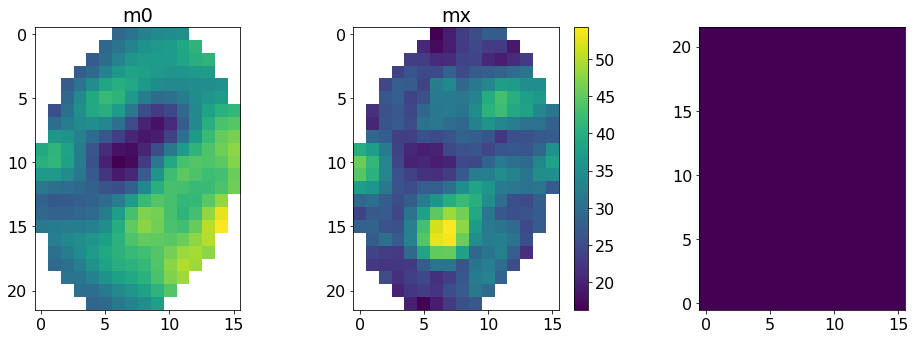

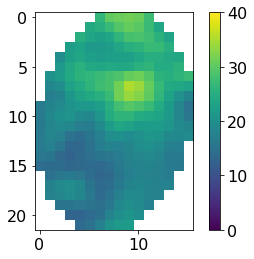

In [65]:
stackKc = stackKc.subcube_from_regions(regdisk)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackKc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackKc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
mskK = (mx) > 0.0001*mx.unit
mskK = scipy.ndimage.binary_erosion(mskK, iterations=1)
mskK = scipy.ndimage.binary_dilation(mskK, iterations=7)
pl.imshow(mskK, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = stackKc.with_mask(mskK).with_mask(stackKc > 0.0005*stackKc.unit).moment1()
pl.imshow(m1.value, vmin=0, vmax=40)
pl.colorbar()
vmapK = m1.hdu

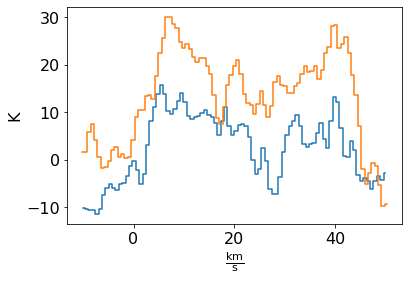

In [66]:
stackKc.mean(axis=(1,2)).quicklook()
stackc.with_mask(msk).mean(axis=(1,2)).quicklook()

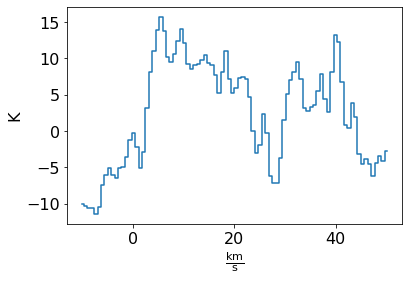

In [67]:
stackKc.with_mask(mskK).mean(axis=(1,2)).quicklook()

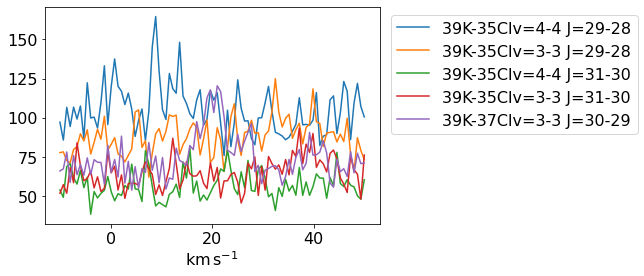

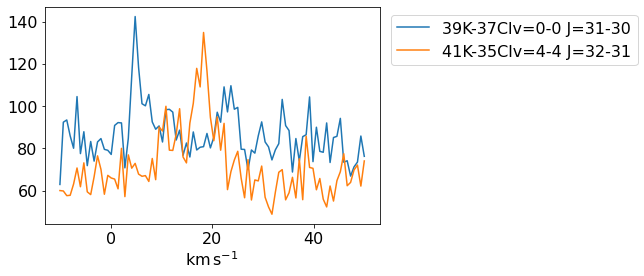

In [68]:
ii = 0
for cutout, linef in zip(cutoutsK, linenamesK):
    if ii == 5:
        pl.figure()
    cutout = SpectralCube(data=cutout, header=stackK.header, wcs=wcs.WCS(stackK.header)).subcube_from_regions([regvsm])
    sp = cutout.max(axis=(1,2))
    pl.plot(sp.spectral_axis, sp.value, label=str(linef))
    pl.legend(loc='upper left', bbox_to_anchor=(1.01,1,0,0))
    ii+=1

In [69]:
cubes[0].with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_axis.diff()

<Quantity [-1.25927148, -1.25927148, -1.25927148, ..., -1.25927148,
           -1.25927148, -1.25927148] km / s>

In [70]:
cubes[1].with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_axis.diff()

<Quantity [0.67005269, 0.67005269, 0.67005269, ..., 0.67005269, 0.67005269,
           0.67005269] km / s>

In [71]:
cubes[2].with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_axis.diff()

<Quantity [-1.24638837, -1.24638837, -1.24638837, ..., -1.24638837,
           -1.24638837, -1.24638837] km / s>

In [72]:
cubes[3].with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_axis.diff()

<Quantity [1.3312065, 1.3312065, 1.3312065, ..., 1.3312065, 1.3312065,
           1.3312065] km / s>

In [73]:
import sys
sys.path.append('/blue/adamginsburg/adamginsburg/repos/pvextractor',)

In [74]:
import show_pv

In [75]:
import pvextractor

In [76]:
endpts = regions.Regions.read('endpts.reg')

In [77]:
#crds = coordinates.SkyCoord(['18:22:26.38475', '18:22:26.3863'], ['-13:30:12.0346', '-13:30:11.9204'], unit=(u.hour, u.deg), frame='icrs')
crds = coordinates.SkyCoord([x.center for x in endpts])
path = pvextractor.Path(crds, width=0.02*u.arcsec)
crds, path

(<SkyCoord (ICRS): (ra, dec) in deg
     [(275.609945, -13.503297), (275.609931, -13.503363)]>,
 <pvextractor.geometry.path.Path at 0x2b6dd828a910>)

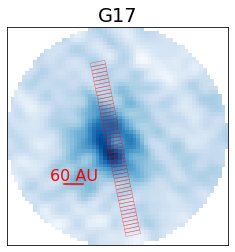

In [78]:
m0 = stackc[:,:,:].moment0()
ax = pl.subplot(projection=m0.wcs)
pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
pl.title("G17")
pl.plot([15,20], [16,16], color='r')
pl.text(17.5, 17, '60 AU', horizontalalignment='center', color='r')
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([])
pl.gca().set_xticks([])
pl.gca().set_yticks([])
ax.coords['ra'].set_ticklabel_visible(False)
ax.coords['dec'].set_ticklabel_visible(False)
ax.coords['ra'].set_ticks_visible(False)
ax.coords['dec'].set_ticks_visible(False)
path.show_on_axis(pl.gca(), edgecolor='r', facecolor='none', spacing=1, linewidth=0.5, alpha=0.5)
pl.savefig("G17_NaCl_mom0_withpath.png", bbox_inches='tight', dpi=300)
pl.savefig("G17_NaCl_mom0_withpath.pdf", bbox_inches='tight', dpi=300)

In [79]:
stackc

DaskSpectralCube with shape=(91, 59, 60) and unit=K and chunk size (91, 59, 60):
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   275.609895 deg:  275.609979 deg
 n_y:     59  type_y: DEC--SIN  unit_y: deg    range:   -13.503365 deg:  -13.503285 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:      -10.197 km / s:      50.245 km / s

In [80]:
x = ax.coords['ra']

In [81]:
rslt = pvextractor.extract_pv_slice(cube=stackc, path=path)

In [82]:
stackc.beam.jtok(217*u.GHz)

<Quantity 30715.72863757 K>

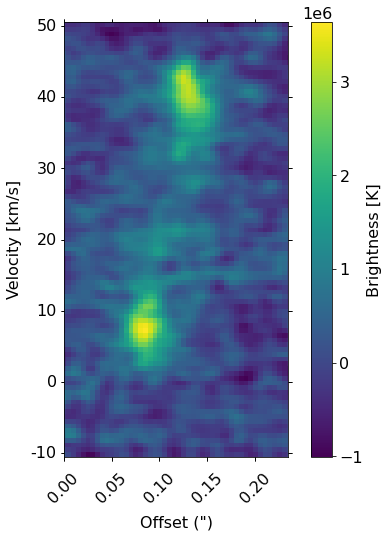

In [83]:
pl.figure(figsize=(8,8))
ww = wcs.WCS(rslt.header)
ax = pl.subplot(projection=ww)
im = ax.imshow(rslt.data * stackc.beam.jtok(217*u.GHz))
cbar = pl.colorbar(im)
ax.set_xlim(0,47)
ax.coords[0].tick_params(labelsize=16)
#https://github.com/astropy/astropy/issues/10717#issuecomment-1009319989
ax.coords[0].set_ticklabel(rotation=45, pad=30)
ax.coords[1].tick_params(labelsize=16)
ax.coords[1].set_format_unit(u.km / u.s)
ax.coords[0].set_format_unit(u.arcsec)
ax.coords[0].set_major_formatter('x.xx')
ax.coords[0].set_axislabel("Offset (\")", fontsize=16)
ax.coords[1].set_axislabel("Velocity [km/s]", fontsize=16)
cbar.set_label('Brightness [K]', fontsize=16)
cbar.ax.tick_params(labelsize=16)
pl.savefig("NaCl_stack_PV_diagram.png", bbox_inches='tight')

In [84]:
c0 = ax.coords[0]

In [85]:
import show_pv
show_pv

<module 'show_pv' from '/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis/show_pv.py'>

In [86]:
from show_pv import show_pv
import imp
import show_pv
imp.reload(show_pv)
from show_pv import show_keplercurves, show_pv


leftmost: 0.0 arcsec
rightmost: 6.5277777777783e-05 arcsec
endpoints_x = [0.105      0.12772727] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


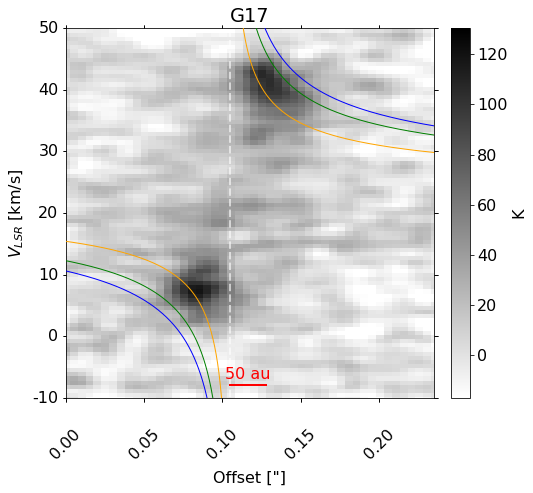

In [87]:
naclpv = rslt = pvextractor.extract_pv_slice(cube=stackc, path=path)
fig,ax,cb,con = show_pv(rslt.data, wcs.WCS(rslt.header), origin=0.105*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([-10,50]), vcen=30*u.km/u.s, imvmin=np.nanpercentile(rslt.data, 3), imvmax=np.nanmax(rslt.data),
                        distance=2.2*u.kpc,
                        xoffset_label=0.105*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 0.105*u.arcsec, 300*u.au, 
                       vcen=u.Quantity(23,u.km/u.s),
                               masses=[15,30,40,],
                               linestyles=['-']*4,
                               colors=['orange','g','b','c'],
                       radii={},
                       distance=2.2*u.kpc,
                       inclination=40*u.deg,
                              )
pl.title("G17")
pl.savefig("G17_naclPV_withcolorcurves.png", bbox_inches='tight')
pl.savefig("G17_naclPV_withcolorcurves.pdf", bbox_inches='tight')
#pl.legend(loc='best')


leftmost: 1.388888888889e-05 arcsec
rightmost: 4.5833333333337e-05 arcsec
endpoints_x = [0.10501389 0.12774116] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


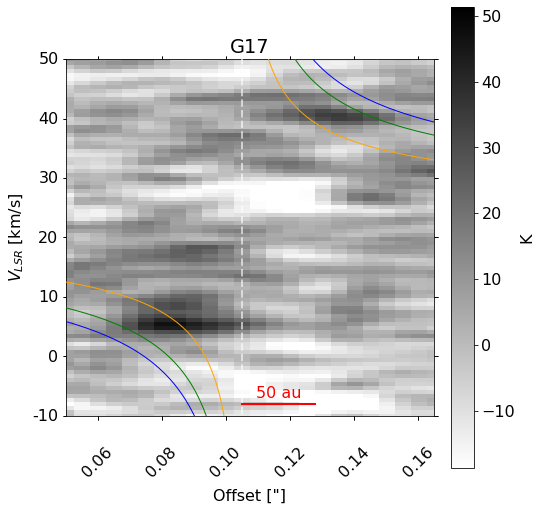

In [88]:
rslt = pvextractor.extract_pv_slice(cube=stackKc, path=path)
fig,ax,cb,con = show_pv(rslt.data, wcs.WCS(rslt.header),
                        origin=0.105*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([-10,50]), vcen=30*u.km/u.s,
                        imvmin=np.nanpercentile(rslt.data, 3), imvmax=np.nanmax(rslt.data),
                        distance=2.2*u.kpc,
                        xoffset_label=0.105*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 0.105*u.arcsec, 600*u.au, 
                       vcen=u.Quantity(23,u.km/u.s),
                               masses=[15,30,40,],
                               linestyles=['-']*4,
                       inclination=40*u.deg,
                               colors=['orange','g','b','c'],
                       radii={},
                       distance=2.2*u.kpc,
                              )
pl.gca().set_aspect(0.25)
pl.title("G17")
pl.savefig("G17_KClPV_withcolorcurves.png", bbox_inches='tight')
pl.savefig("G17_KClPV_withcolorcurves.pdf", bbox_inches='tight')
#pl.legend(loc='best')

In [89]:
stackKc2 = SpectralCube.read('KCl_v_le_4_stackcube.fits').subcube_from_regions([regvsm])
rsltK = pvextractor.extract_pv_slice(cube=stackKc2, path=path)

leftmost: 0.0 arcsec
rightmost: 6.5277777777783e-05 arcsec
endpoints_x = [0.105      0.12772727] arcsec


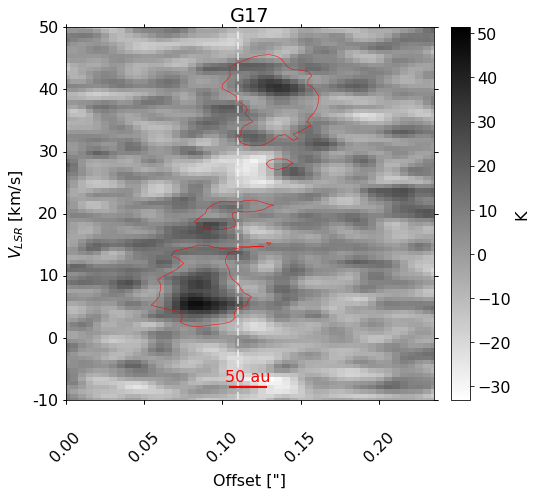

In [90]:
fig,ax,cb,con = show_pv(rsltK.data, wcs.WCS(rsltK.header), origin=0.11*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([-10,50]), vcen=30*u.km/u.s, imvmin=np.nanmin(rsltK.data), imvmax=np.nanmax(rsltK.data),
                        distance=2.2*u.kpc,
                        xoffset_label=0.105*u.arcsec
                    )
cb.set_label("K")
pl.title("G17")
ax.contour(naclpv.data, levels=[35], colors=['r','r'], linewidths=[0.5,0.5],
           transform=ax.get_transform(wcs.WCS(naclpv.header)))
pl.savefig("G17_KClstack_withNaClcontours.png", bbox_inches='tight')
pl.savefig("G17_KClstack_withNaClcontours.pdf", bbox_inches='tight')

In [91]:
rsltwater = pvextractor.extract_pv_slice(cube=water_cube, path=path)

leftmost: 0.0 arcsec
rightmost: 6.5277777777783e-05 arcsec
endpoints_x = [0.105      0.12772727] arcsec


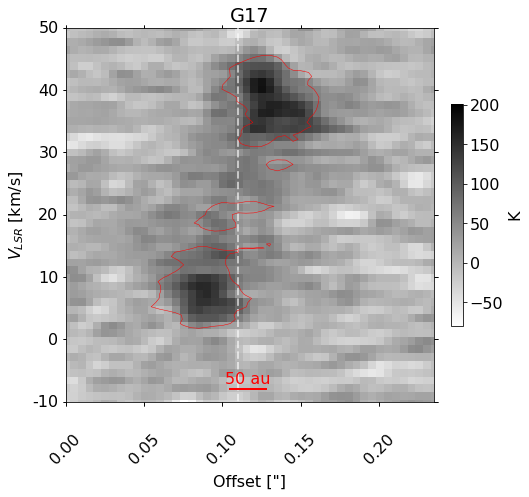

In [92]:
fig,ax,cb,con = show_pv(rsltwater.data, wcs.WCS(rsltwater.header),
                        origin=0.11*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([-10,50]), vcen=30*u.km/u.s, imvmin=np.nanmin(rsltwater.data), imvmax=np.nanmax(rsltwater.data),
                        distance=2.2*u.kpc,
                        xoffset_label=0.105*u.arcsec                        
                    )
cb.set_label("K")
pl.title("G17")
ax.contour(naclpv.data, levels=[35], colors=['r','r'], linewidths=[0.5,0.5],
           transform=ax.get_transform(wcs.WCS(naclpv.header)))
ax.set_aspect(1.)
pl.savefig("G17_water_withNaClcontours.png", bbox_inches='tight')
pl.savefig("G17_water_withNaClcontours.pdf", bbox_inches='tight')

leftmost: 0.0 arcsec
rightmost: 6.5277777777783e-05 arcsec
endpoints_x = [0.105      0.12772727] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


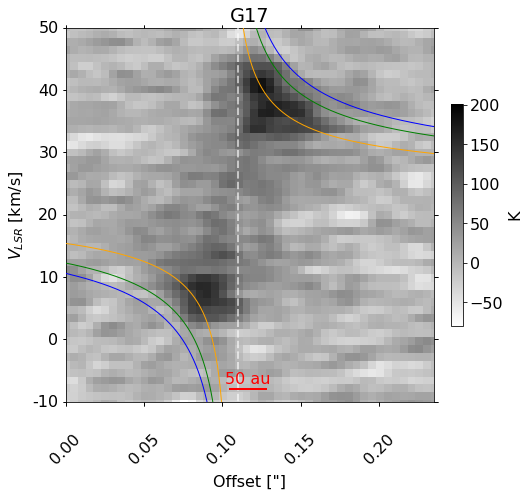

In [93]:
fig,ax,cb,con = show_pv(rsltwater.data, wcs.WCS(rsltwater.header),
                        origin=0.11*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([-10,50]), vcen=30*u.km/u.s, imvmin=np.nanmin(rsltwater.data), imvmax=np.nanmax(rsltwater.data),
                        distance=2.2*u.kpc,
                        xoffset_label=0.105*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 0.105*u.arcsec, 300*u.au, 
                       vcen=u.Quantity(23,u.km/u.s),
                               masses=[15,30,40,],
                               linestyles=['-']*4,
                       inclination=40*u.deg,
                               colors=['orange','g','b','c'],
                       radii={},
                       distance=2.2*u.kpc,
                              )
pl.title("G17")
ax.set_aspect(1)
pl.savefig("G17_waterPV_withcolorcurves.png", bbox_inches='tight')
pl.savefig("G17_waterPV_withcolorcurves.pdf", bbox_inches='tight')

In [94]:
rslth30a = pvextractor.extract_pv_slice(cube=h30a_cube, path=path)

In [95]:
from astropy.convolution import convolve, Gaussian1DKernel

In [96]:
def conv(x):
    return convolve(x, Gaussian1DKernel(3))
smd = np.array(list(map(conv, rslth30a.data.T))).T

(-0.5, 47.5, 127.5, -0.5)

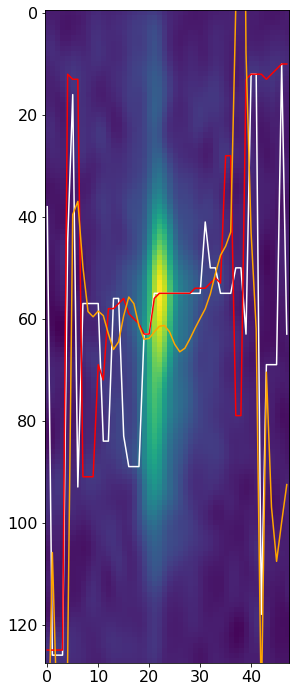

In [97]:
pl.figure(figsize=(12,12))
pl.imshow(rslth30a.data)
pl.imshow(smd)
axlim = pl.axis()
pl.plot(rslth30a.data.argmax(axis=0), color='w')
pl.plot(smd.argmax(axis=0), color='r')
m1h30apix = (rslth30a.data * np.arange(rslth30a.data.shape[0])[:,None]).sum(axis=0) / (rslth30a.data.sum(axis=0))
pl.plot(m1h30apix,
       color='orange')
pl.axis(axlim)

In [98]:
m1h30apix[22]

61.46802911754998

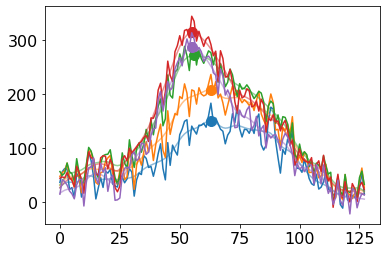

In [99]:
for xpix in range(19,24):
    L, = pl.plot(rslth30a.data[:,xpix])
    pl.plot(smd[:,xpix], color=L.get_color(), alpha=0.5)
    pl.plot(smd[:,xpix].argmax(), smd[smd[:,xpix].argmax(), xpix], 'o', markersize=10, color=L.get_color())
    #pl.plot(m1h30apix[xpix], rslth30a.data[int(m1h30apix[xpix]),xpix], 'o', markersize=10, color=L.get_color())

In [100]:
wh30a = wcs.WCS(rslth30a.header)
_,vel = wh30a.pixel_to_world(0, np.arange(rslth30a.data.shape[0]))
offset,_ = wh30a.pixel_to_world(np.arange(rslth30a.data.shape[1]), 0)
m1h30a = (rslth30a.data * vel[:,None].to(u.km/u.s)).sum(axis=0) / (rslth30a.data.sum(axis=0))
m0h30a = (rslth30a.data.sum(axis=0))

leftmost: 0.0 arcsec
rightmost: 6.5277777777783e-05 arcsec
endpoints_x = [0.105      0.12772727] arcsec


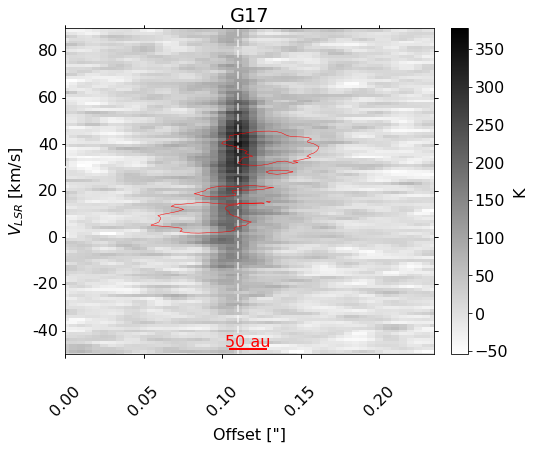

In [101]:
fig,ax,cb,con = show_pv(rslth30a.data, wcs.WCS(rslth30a.header),
                        origin=0.11*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([-50,90]), vcen=30*u.km/u.s, imvmin=np.nanmin(rslth30a.data), imvmax=np.nanmax(rslth30a.data),
                        distance=2.2*u.kpc,
                        xoffset_label=0.105*u.arcsec                        
                    )
#ax.plot(offset[m0h30a>5000],
#        m1h30a[m0h30a>5000],
#        color='orange',
#        transform=ax.get_transform('world')
#       )
cb.set_label("K")
pl.title("G17")
ax.contour(naclpv.data, levels=[35], colors=['r','r'], linewidths=[0.5,0.5],
           transform=ax.get_transform(wcs.WCS(naclpv.header)))
pl.savefig("G17_h30a_withNaClcontours.png")

# Comparison to Orion Source I

In [102]:
from astropy.io import fits
orinacl = fits.open('/orange/adamginsburg/orion/2016.1.00165.S/FITS/pv/sourceI_NaClv=1_18-17_B6_robust0.5_diskpv_0.01.fits')[0]

leftmost: 1.4444444411384001e-05 arcsec
rightmost: 0.000196666666216536 arcsec
endpoints_x = [0.40001444 0.52501444] arcsec


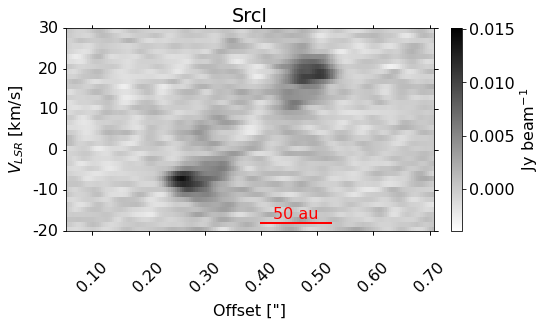

In [103]:
fig,ax,cb,con = show_pv(orinacl.data, wcs.WCS(orinacl.header), origin=0*u.arcsec, # coordinates.SkyCoord("5:35:14.519", "-5:22:30.633", frame='fk5',                             unit=(u.hour, u.deg)),
                        distance=400*u.pc,
                        xoffset_label=0.4*u.arcsec,
                vrange=np.array([-20,30]), vcen=5*u.km/u.s, imvmin=np.nanmin(orinacl.data), imvmax=np.nanmax(orinacl.data),
                    )
cb.set_label("Jy beam$^{-1}$")
pl.title('SrcI')
pl.savefig("SrcI")
#ax.contour(rslt.data, levels=[0.0015, ], colors=['r','r'], linewidths=[0.5,0.5], transform=ax.get_transform(wcs.WCS(orinacl.header)))

In [104]:
import imp
import show_pv
imp.reload(show_pv)
from show_pv import show_keplercurves, show_pv

leftmost: 1.4444444411384001e-05 arcsec
rightmost: 0.000196666666216536 arcsec
endpoints_x = [0.40001444 0.52501444] arcsec


divide by zero encountered in true_divide


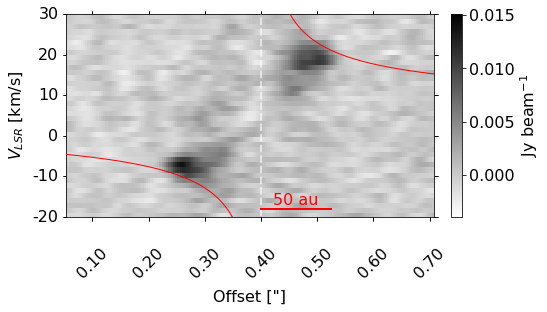

In [105]:
ori_origin = coordinates.SkyCoord("5:35:14.519", "-5:22:30.633", frame='fk5',
                             unit=(u.hour, u.deg))
fig,ax,cb,con = show_pv(orinacl.data, wcs.WCS(orinacl.header), origin=0.4*u.arcsec, #ori_origin,
                        distance=400*u.pc,
                        xoffset_label=0.4*u.arcsec,
                vrange=np.array([-20,30]), vcen=5*u.km/u.s, imvmin=np.nanmin(orinacl.data), imvmax=np.nanmax(orinacl.data),
                    )
cb.set_label("Jy beam$^{-1}$")
kc = show_keplercurves(ax, 0.4*u.arcsec, 150*u.au, u.Quantity(5,u.km/u.s),
                               masses=[15,],
                               linestyles='-',
                               colors=['r'],
                       radii={}
                              )
pl.savefig("SrcI_withKepler.png")

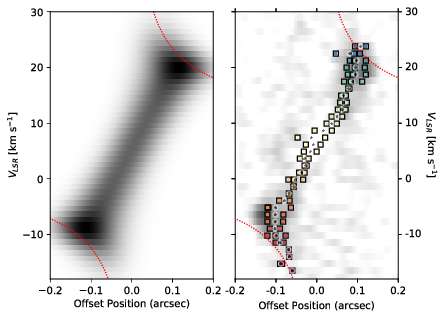

In [106]:
from wand.image import Image as WImage
img = WImage(filename='/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/paper_sourceImass/figures/Unknown_4_pp_pv_plots_fittedmodel_15msun_withavgs_comparepv.pdf')
img

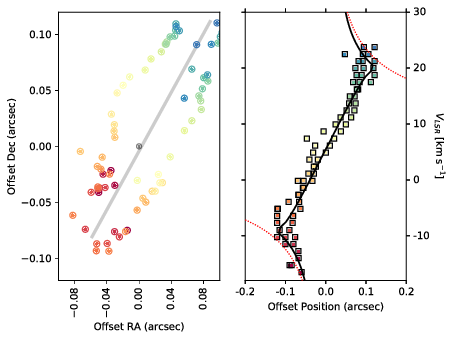

In [107]:
WImage(filename='/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/paper_sourceImass/figures/Unknown_4_pp_pv_plots.pdf')

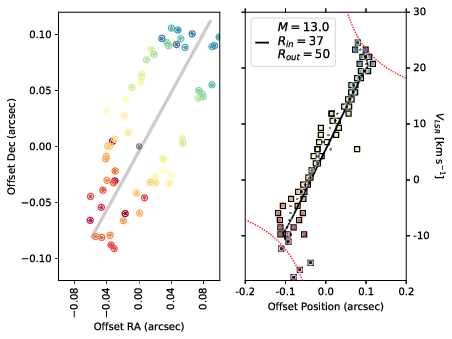

In [108]:
WImage(filename='/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/paper_sourceImass/figures/Unknown_1_pp_pv_plots_fittedmodel_withavgs.pdf')

In [109]:
print("TEST")

TEST


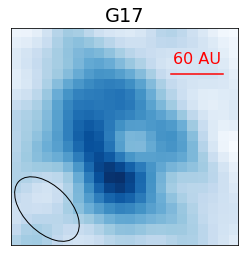

In [110]:
m0 = stackc[:,18:-20,18:-20].moment0()

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
pl.title("G17")
pl.plot([15,20], [16,16], color='r')
pl.text(17.5, 17, '60 AU', horizontalalignment='center', color='r')
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([])
pl.gca().set_xticks([])
pl.gca().set_yticks([])

bm = stackc.beam
bmell = bm.ellipse_to_plot(3, 3, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)

pl.savefig("G17_NaCl_mom0.png", bbox_inches='tight', dpi=300)

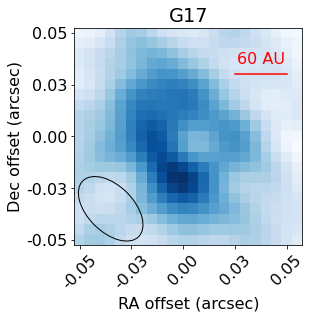

In [111]:
m0 = stackc[:,18:-20,18:-20].moment0()

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

pl.title("G17")
pl.plot([15,20], [16,16], color='r')
pl.text(17.5, 17, '60 AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(stackc.wcs.celestial)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xtlocs-10)*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-10)*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)

ax.axis(axlims)

bm = stackc.beam
bmell = bm.ellipse_to_plot(3, 3, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)

ax.set_xlabel("RA offset (arcsec)")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("G17_NaCl_mom0_ticks.png", bbox_inches='tight', dpi=300)

In [112]:
naclv1ori = SpectralCube.read('https://zenodo.org/record/2365835/files/OrionSourceI_U232.511_robust0.5maskedclarkclean10000_medsub_K.fits')
naclv1ori.beam_threshold=1

In [113]:
oripxscale = naclv1ori.wcs.proj_plane_pixel_scales()[0]
oripxscale_au = (oripxscale * 400*u.pc).to(u.au, u.dimensionless_angles())
oripxscale_au

<Quantity 1.6 AU>

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


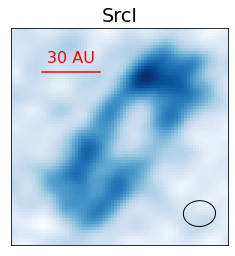

In [114]:
m0 = naclv1ori[:,28:100,30:102].moment0()
pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
pl.title("SrcI")
pl.plot([10,29], [57, 57], color='r')
pl.text(39/2, 60, f'{int(19*oripxscale_au.value):d} AU', horizontalalignment='center', color='r')
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([])
pl.gca().set_xticks([])
pl.gca().set_yticks([])
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(naclv1ori.wcs.celestial)**0.5*u.deg).to(u.arcsec))
bm = naclv1ori.beams.common_beam()
bmell = bm.ellipse_to_plot(m0.shape[1]-10, 10, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)
pl.savefig("SrcI_NaCl_mom0.png", bbox_inches='tight', dpi=300)

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


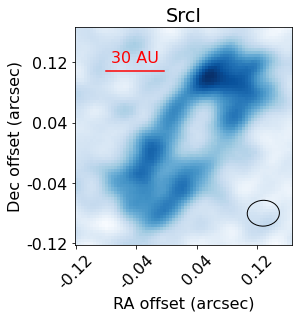

In [115]:
m0 = naclv1ori[:,28:100,30:102].moment0()

pl.imshow(m0.value, cmap='Blues', origin='lower',)# vmax=m0.value.max()*2,)
          #norm=simple_norm(m0.value, stretch='log', max_cut=m0.value.max()*10))
ax = pl.gca()

pl.title("SrcI")
pl.plot([10,29], [57, 57], color='r')
pl.text(39/2, 60, f'{int(19*oripxscale_au.value):d} AU', horizontalalignment='center', color='r')
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(naclv1ori.wcs.celestial)**0.5*u.deg).to(u.arcsec))
axlims = ax.axis()

xtlocs = ax.get_xticks()
xticklabels = map(lambda x: f"{x:0.2f}", (xtlocs-np.median(xtlocs))*pixscale.value)
pl.xticks(xtlocs, xticklabels, rotation=45)

ytlocs = ax.get_yticks()
yticklabels = map(lambda x: f"{x:0.2f}", (ytlocs-np.median(xtlocs))*pixscale.value)
pl.yticks(ytlocs, yticklabels, rotation=0)

ax.axis(axlims)

bm = naclv1ori.beams.common_beam()
bmell = bm.ellipse_to_plot(m0.shape[1]-10, 10, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
pl.gca().add_artist(bmell)

ax.set_xlabel("RA offset (arcsec)")
ax.set_ylabel("Dec offset (arcsec)")
pl.savefig("SrcI_NaCl_mom0_ticks.png", bbox_inches='tight', dpi=300)

In [116]:
vcen = 30*u.km/u.s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


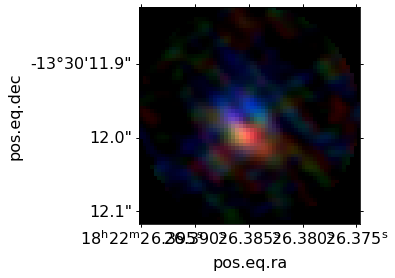

In [117]:
m0b = stackc.spectral_slab(vcen-20*u.km/u.s, vcen-5*u.km/u.s).moment0()
m0g = stackc.spectral_slab(vcen-5*u.km/u.s, vcen+5*u.km/u.s).moment0()
m0r = stackc.spectral_slab(vcen+5*u.km/u.s, vcen+20*u.km/u.s).moment0()
ax = pl.subplot(projection=m0b.wcs.celestial)
rgb = np.array([m0r.value, m0g.value, m0b.value]).swapaxes(0,2).swapaxes(0,1)
rgb /= np.nanmax(rgb)
ax.imshow(rgb, origin='lower')

cont = SpectralCube.read('IRAS165474247_G343.12-0.06.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
fig = pl.figure()
fig.add_subplot(projection=cont.wcs.celestial)
ax = fig.gca()
ax.imshow(cont.value)
ax.contour(m0r, colors=['r']*5)
ax.contour(m0b, colors=['b']*5)

# Indriolo stacks

In [118]:
indriolocubes = [SpectralCube.read(fn).subcube_from_regions([reg]).to(u.K) for fn in glob.glob('indriolo/*.cube.I.pbcor.fits')]

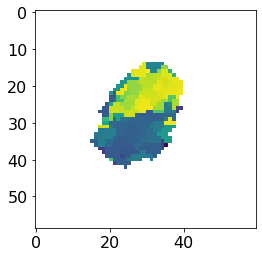

In [119]:
pl.imshow(vmap.data)

fn=indriolo/member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor.fits, basename=member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor
DaskSpectralCube with shape=(117, 1512, 1512) and unit=Jy / beam and chunk size (117, 504, 504):
 n_x:   1512  type_x: RA---SIN  unit_x: deg    range:   275.605624 deg:  275.614257 deg
 n_y:   1512  type_y: DEC--SIN  unit_y: deg    range:   -13.507525 deg:  -13.499130 deg
 n_s:    117  type_s: FREQ      unit_s: Hz     range: 320862444133.800 Hz:322674981068.195 Hz


fn=indriolo/member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor.fits, basename=member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor
DaskSpectralCube with shape=(958, 1512, 1512) and unit=Jy / beam and chunk size (322, 252, 252):
 n_x:   1512  type_x: RA---SIN  unit_x: deg    range:   275.605624 deg:  275.614257 deg
 n_y:   1512  type_y: DEC--SIN  unit_y: deg    range:   -13.507525 deg:  -13.499130 deg
 n_s:    958  type_s: FREQ      unit_s: Hz     range: 322207907626.600 Hz:322675331595.630 Hz


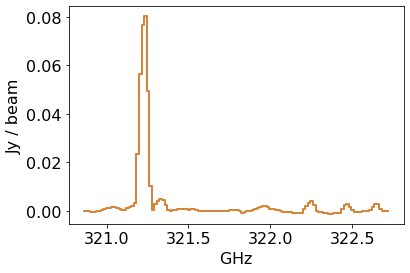

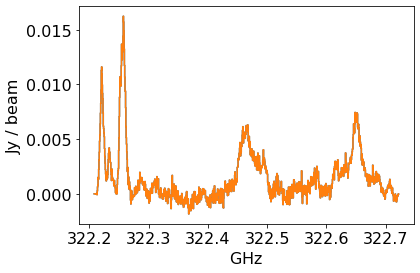

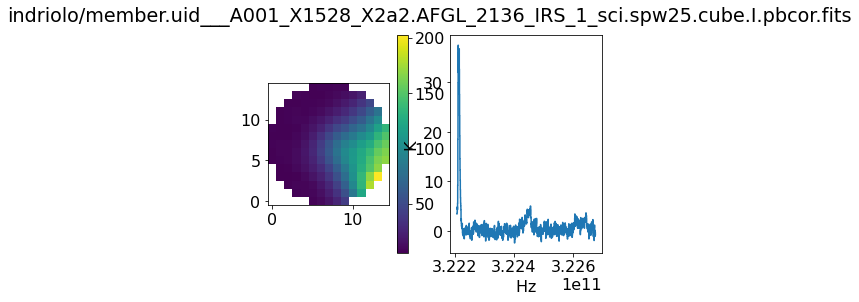

In [120]:
import glob
import spectral_cube.analysis_utilities
import reproject

flist = glob.glob('indriolo/*.cube.I.pbcor.fits')
for fn in flist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    print(f"fn={fn}, basename={basename}")
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions([regvsm]).to(u.K)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)

    # convert the cube to velocity units with an arbitrary reference point
    # (this step assumes the cube is in frequency or wavelength; if the
    # cube is not, it should be skipped)
    if not cube.spectral_axis.unit.is_equivalent(u.km/u.s):
        fullcube = cube.with_spectral_unit(u.km/u.s,
                                           velocity_convention='radio',
                                           rest_value=cube.spectral_axis.mean())
    else:
        fullcube = cube

    commonbeam = fullcube.beam

    scube = fullcube.subcube_from_regions([regvsm])#.convolve_to(fullcube.beams.common_beam())

    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)


    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s)
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor_stack.fits
[('39K-35Clv=4-4 J=43-42', <Quantity 321.53374112 GHz>), ('39K-35Clv=0-0 J=42-41', <Quantity 321.97555861 GHz>), ('39K-37Clv=3-3 J=44-43', <Quantity 321.71671112 GHz>), ('41K-35Clv=4-4 J=44-43', <Quantity 321.50123752 GHz>), ('41K-35Clv=0-0 J=43-42', <Quantity 322.02440848 GHz>), ('23Na-35Clv=1-1 J=25-24', <Quantity 322.649998 GHz>), ('23Na-37Clv=4-4 J=26-25', <Quantity 321.157577 GHz>)]
member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor_stack.fits
[('23Na-35Clv=1-1 J=25-24', <Quantity 322.649998 GHz>)]


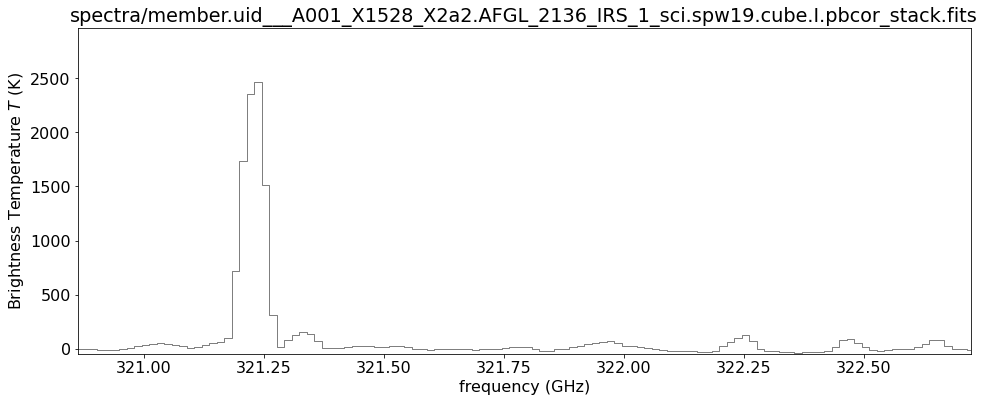

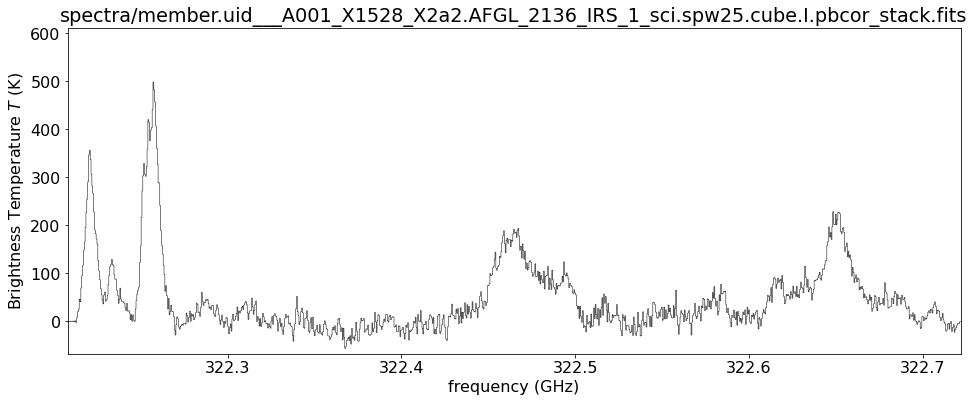

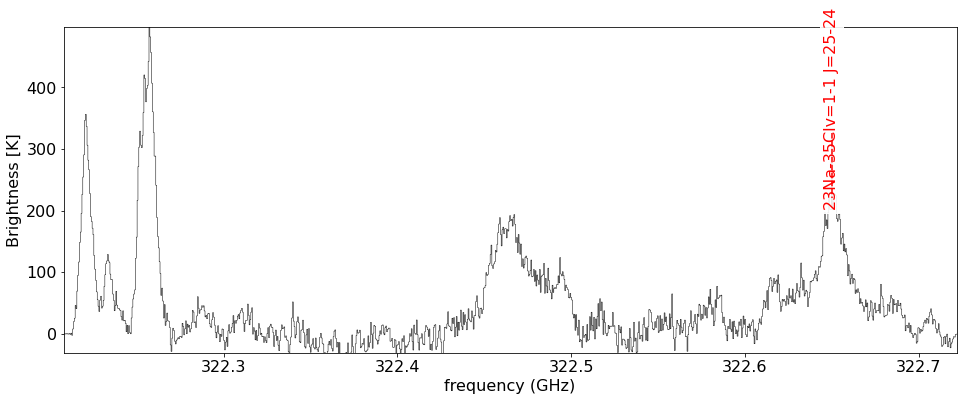

In [121]:
# (vcen in the stacked centroid is defined to be zero)
vcen_ = 0*u.km/u.s

indriolospectra = []

jtok = stackc.beam.jtok(217*u.GHz)

for fn in glob.glob("spectra/*AFGL_2136*stack.fits"):

    sp = pyspeckit.Spectrum(fn)

    if sp.unit != u.K:
        sp.data *= jtok.value
        sp.unit = u.K
    
    fig = pl.figure(figsize=(16,6))
    sp.plotter(figure=fig)
    pl.title(fn)
    
    sp.specname = fn
    
    indriolospectra.append(sp)

pl.matplotlib.rcParams['font.size']=16

all_lines = {**lines.disk_lines, **lines.absorbers}

ided_linenames = sorted(all_lines.keys())
ided_linefreqs = u.Quantity([all_lines[x] for x in ided_linenames
                             #if 'U' not in x
                            ])
ided_linetexnames = [lines.texnames[x] if x in lines.texnames else x
                     for x in ided_linenames
                     #if 'U' not in x
                    ]

#salt_tables = [KCl, K37Cl, K41Cl, NaCl, Na37Cl, K41Cl37]
salt_colors = ['b', 'm', 'darkgreen', 'orange', 'c', 'y']

# table5 is 41K-37Cl
tables = salt_tables[:5]

def linename(row):
    return row['Species'] #"{0} {1}".format(row['Species'], row['QNs'])
def freq(row):
    return u.Quantity(row['Freq'], u.GHz)

#linenames = [linename(row) for tbl in tables for row in tbl if row['vu'] <=4]
rows = [row for tbl in tables for row in tbl if row['vu'] <=4]
linetexnames = [linename(row) for row in rows] + ided_linetexnames
linetexnames = np.array(linetexnames)
linefreqs = np.hstack([u.Quantity([freq(row) for row in rows], u.GHz).value,
                       ided_linefreqs.value])
linefreqs = u.Quantity(linefreqs, u.GHz)

#detection_table = table.Table.read(paths.tpath('salts_in_band.ipac'), format='ascii.ipac')
#nondetections = (detection_table['Flag'] == '-n') | (detection_table['Flag'] == 'cn')
#detection_table = detection_table[~nondetections]

paths.fpath = lambda x: f"spectra/figures/{x}"


for sp_st in indriolospectra:
    
    sp_st.xarr.convert_to_unit(u.GHz)
    
    basefn = os.path.basename(sp_st.specname)
    print(basefn)
    
    pl.figure(0, figsize=(16,6)).clf()
    sp_st.plotter(figure=pl.figure(0, figsize=(16,6)), clear=True)

    lines_to_plot = ((linefreqs > sp_st.xarr.as_unit(linefreqs.unit).min()*(1-vcen_/constants.c)) &
                     (linefreqs < sp_st.xarr.as_unit(linefreqs.unit).max()*(1+vcen_/constants.c)))
    print(list(zip(linetexnames[lines_to_plot], linefreqs[lines_to_plot])))
    
    ymax = sp_st.data.max()
    ymin = sp_st.data.min()
    if ymax < 0.004*jtok.value:
        ymax = 0.004*jtok.value
    if ymin < -0.001*jtok.value:
        ymin = -0.001*jtok.value
    sp_st.plotter(ymax=ymax, ymin=ymin)
    
    sp_st.plotter.line_ids(linetexnames[lines_to_plot], linefreqs[lines_to_plot], velocity_offset=vcen_,
                           label1_size=16,
                           auto_yloc_fraction=0.75)
    for txt in sp_st.plotter.axis.texts:
        txt.set_backgroundcolor((1,1,1,0.9))
        
    sp_st.plotter.axis.set_title(basefn.split("_")[1])
    sp_st.plotter.axis.set_ylabel("Brightness [K]")


    sp_st.plotter.savefig(paths.fpath('{0}'
                                      .format(basefn.replace("fits","png"))),
                          bbox_inches='tight'
                          )

    for obj in sp_st.plotter.axis.texts+sp_st.plotter.axis.lines:
        if 'Na' in obj.get_label():
            obj.set_color('r')
            obj.set_zorder(5)
        elif 'K' in obj.get_label():
            obj.set_color('b')
            obj.set_zorder(10)
    for txt in sp_st.plotter.axis.texts:
        txt.set_backgroundcolor((1,1,1,0.9))

    sp_st.plotter.savefig(paths.fpath('color_labels_{0}'
                                      .format(basefn.replace("fits","png"))),
                          bbox_inches='tight'
                          )

In [122]:
ls spectra/*AFGL_2136*stack.fits

spectra/member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw19.cube.I.pbcor_stack.fits
spectra/member.uid___A001_X1528_X2a2.AFGL_2136_IRS_1_sci.spw25.cube.I.pbcor_stack.fits


In [123]:
ls figures/spectra

ls: cannot access figures/spectra: No such file or directory


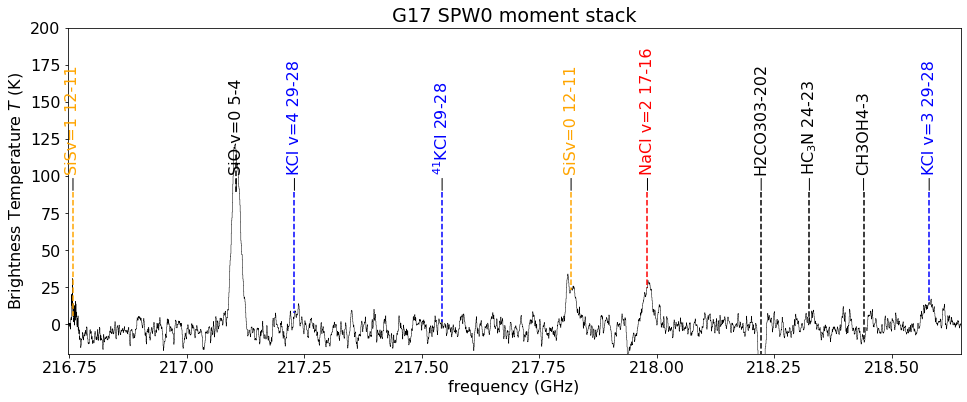

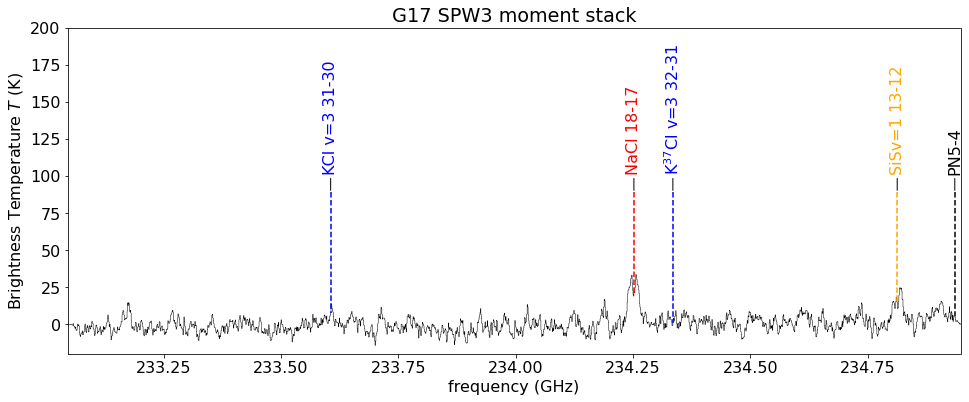

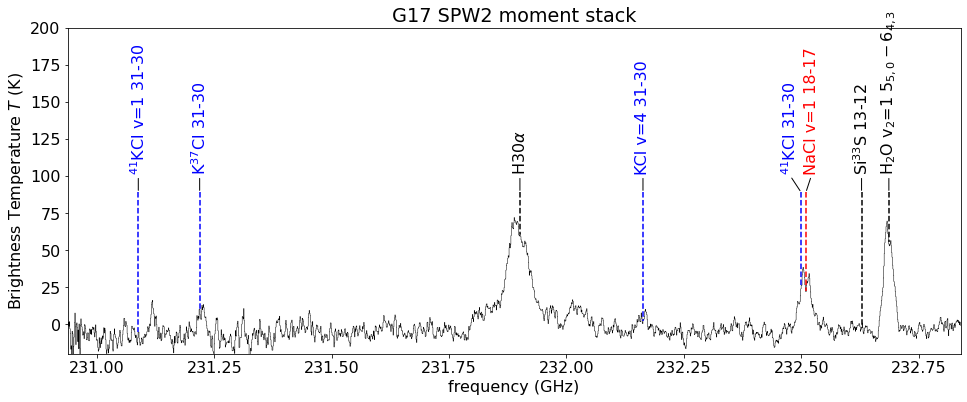

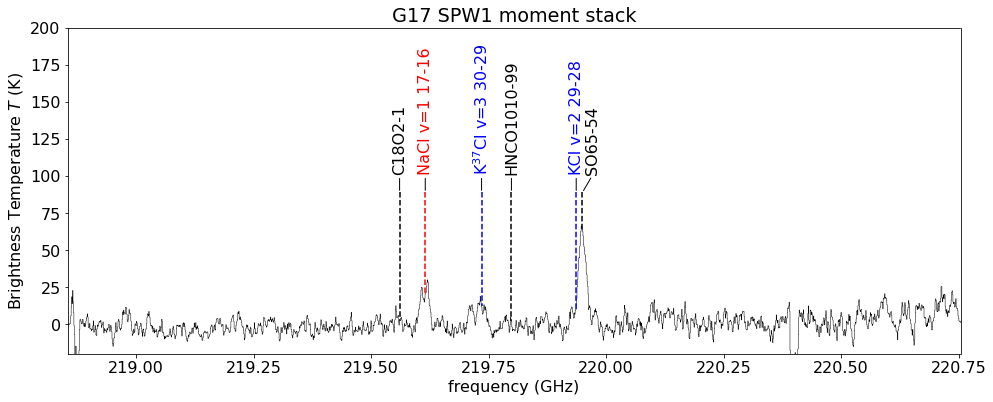

In [124]:
for fn in glob.glob('spectra/figures/color_labels_G17_SPW[0-4]_moment_stack.png'):
    display(Image(fn))

In [125]:
from astroquery.splatalogue import Splatalogue

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist


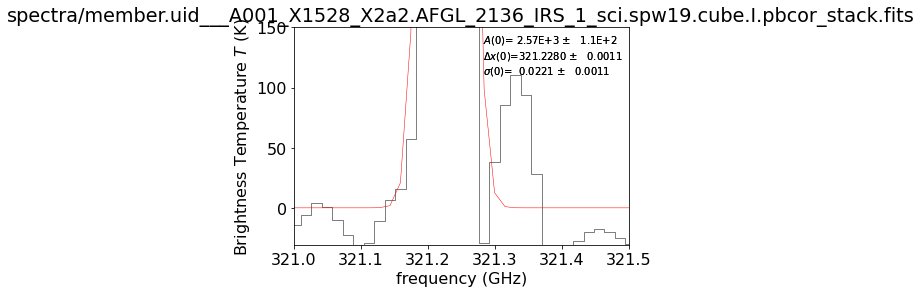

In [126]:
sp = indriolospectra[0]
lx,ux = 321, 321.5
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=150)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit #* (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
tbl = Splatalogue.query_lines(cen-dx, cen+dx, energy_max=10000, energy_type='eu_k', chemical_name='SiS')
tbl.show_in_notebook(display_length=150)